In [1]:
import gym
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import display, clear_output, Image
import numpy as np
import pandas as pd
import random
import itertools
import tools
import sys
from collections import defaultdict
import pdb   # For debugging
import plotting

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Check gym version
print ("Gym version is:", gym.__version__)

Gym version is: 0.26.2


In [3]:
# Starts with creating the Environment)
env = gym.make("CliffWalking-v0", render_mode="rgb_array")

In [4]:
# Reset the environment to its initial state
observation = env.reset()

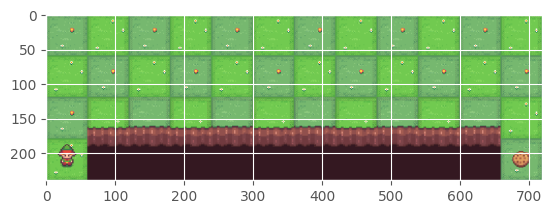

In [5]:
# For render_mode = rbg_array
# Render the environment and display the initial frame
frame = env.render()
plt.imshow(frame)
plt.show()

In [6]:
action = ["up", "right", "down", "left"]

In [7]:
# 4x12 grid = 48 states
print ("Number of states:", env.nS)
# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

Number of states: 48
Number of actions that an agent can take: 4


In [8]:
# Where am I? -> in "x" state
print ("Current state", env.s)
# What are my options? -> 4 actions
print ("Transitions from current state:", env.P[env.s])

Current state 36
Transitions from current state: {0: [(1.0, 24, -1, False)], 1: [(1.0, 36, -100, False)], 2: [(1.0, 36, -1, False)], 3: [(1.0, 36, -1, False)]}


Action taken: right
Transition probability: {'prob': 1.0}
Next state: 36
Reward received: -100
Truncated by max steps: False
Terminal state: False


C:\Users\lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


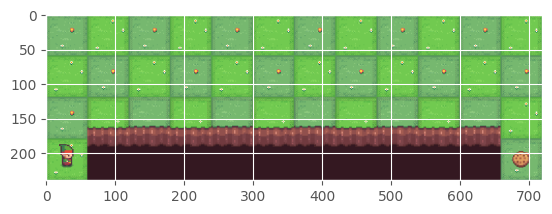

In [9]:
# Taking a step by selecting a random action[up=0, right=1, down=2, left=3] from current state
# next state: Where do I end up?
# reward: What rewards did I receive?
# is_terminal: did I end up in the goal state?
# t_prob: What is the probability of ending up in the next state taking that action?
# New 5th value returned from step:  observation, reward, done, TRUNCATED, info
# truncated = Is the maximum number of steps done?
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, truncated, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward received:", reward)
print ("Truncated by max steps:", truncated)
print ("Terminal state:", is_terminal)
frame = env.render()
plt.imshow(frame)
plt.show()

# 4. Implementing Dynamic Programming algorithms

## Implement the Policy Iteration algorithm. 
Policy Iteration can be outlined as follows:

1. Integrate policy evaluation and policy improvement: The process involves iterating between policy evaluation (pi(0) -> v(pi(0)) -> pi(1) -> v(pi(1)) -> ...) and policy improvement, eventually converging to the optimal policy (pi(optimal)).

2. Finite MDP has a finite policy set: In a finite Markov Decision Process (MDP), there exists a finite collection of policies.

3. Convergence is a necessary condition: Throughout the policy iteration process, it is imperative that the sequence converges to the optimal policy.


In [10]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def policy_evaluation(policy, env, gamma, theta):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):  # Evaluate for all states
            if not is_cliff_or_terminal(s, env):
                v = V[s]
                V[s] = sum([action_prob * sum([prob * (reward + gamma * V[next_state])
                                for prob, next_state, reward, done in env.P[s][a]])
                            for a, action_prob in enumerate(policy[s])])
                delta = max(delta, np.abs(v - V[s]))
        if delta < theta:
            break
    return V

def is_cliff_or_terminal(state, env):
    # Check if the state is the cliff or terminal state
    return state in range(37, 48)  # Adjust if the cliff and terminal states change

def policy_improvement(V, env, gamma):
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        if not is_cliff_or_terminal(s, env):
            q_values = one_step_lookahead(env, s, V, gamma)
            best_action = np.argmax(q_values)
            policy[s, best_action] = 1.0
    return policy

def one_step_lookahead(env, state, V, gamma):
    A = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[state][a]:
            A[a] += prob * (reward + gamma * V[next_state])
    return A

def policy_iteration(env, gamma, theta):
    policy = np.ones([env.nS, env.nA]) / env.nA  # Start with a random policy
    V = np.zeros(env.nS)
    while True:
        V = policy_evaluation(policy, env, gamma, theta)
        new_policy = policy_improvement(V, env, gamma)
        if np.all(policy == new_policy):
            break
        policy = new_policy
    return policy, V

def simulate_policy(policy, env, shape):
    start_state = np.ravel_multi_index((3, 0), shape)
    goal_state = np.ravel_multi_index((3, 11), shape)
    current_state = start_state
    route = []
    action_symbols = ['↑', '→', '↓', '←']

    while current_state != goal_state:
        best_action = np.argmax(policy[current_state])
        route.append((current_state, best_action))
        # Assuming deterministic environment
        prob, next_state, _, _ = env.P[current_state][best_action][0]
        current_state = next_state

    return route

def plot_simulated_policy(policy, env, shape):
    # Get the route of the optimal policy
    route = simulate_policy(policy, env, shape)
    route_grid = np.full(shape, ' ')  # Initialize with blank spaces

    # Symbols for each action
    action_symbols = ['↑', '→', '↓', '←']

    for state, action in route:
        x, y = np.unravel_index(state, shape)
        route_grid[x, y] = action_symbols[action]

    # Print the route as a 2D array of symbols
    print("Optimal Route:")
    for row in route_grid:
        print(" ".join(row))


def plot_policy(policy, shape):
    # Define arrow symbols for each action
    action_symbols = ['↑', '→', '↓', '←']

    # Reshape the policy to the environment shape
    policy_grid = np.argmax(policy, axis=1).reshape(shape)
    symbol_grid = np.array([action_symbols[action] for action in policy_grid.flatten()]).reshape(shape)

    # Update symbols for cliff locations
    for i in range(shape[0]):
        for j in range(shape[1]):
            if i == 3 and 1 <= j <= 10:  # Cliff locations
                symbol_grid[i, j] = 'X'

    # Define a color map for the policy directions and the cliff
    cmap = mcolors.ListedColormap(['skyblue', 'lightgreen', 'salmon', 'wheat', 'gray'])
    bounds = [0, 1, 2, 3, 4, 5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Create a grid to represent the policy
    policy_color_grid = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            policy_color_grid[i, j] = policy_grid[i, j]

    # Plotting
    fig, ax = plt.subplots()
    policy_plot = ax.imshow(policy_color_grid, cmap=cmap, norm=norm)

    # Adding gridlines and setting ticks
    ax.set_xticks(np.arange(-.5, shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)

    # Adding direction symbols and "X" for cliff
    for i in range(shape[0]):
        for j in range(shape[1]):
            text = ax.text(j, i, symbol_grid[i, j], ha="center", va="center", color="black")

    # Print the policy as a 2D array of symbols
    print("Policy as 2D Array of Symbols:")
    for row in symbol_grid:
        print(" ".join(row))

    plt.show()




Optimal Policy:
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


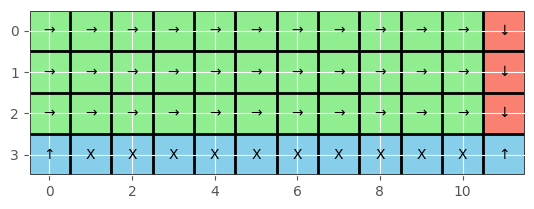

Optimal Value Function:
-13.13 -12.25 -11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97
-12.25 -11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97  -1.99
-11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97  -1.99  -1.00
-12.25   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      


In [11]:
if __name__ == "__main__":
    env = gym.make("CliffWalking-v0")
    gamma = 0.99
    theta = 1e-10
    optimal_policy, optimal_V = policy_iteration(env, gamma, theta)
    
    print("Optimal Policy:")
    plot_policy(optimal_policy, (4, 12))
    
    print("Optimal Value Function:")
    for row in np.reshape(optimal_V, (4, 12)):
        print(" ".join(f"{value:6.2f}" for value in row))
        
    plot_simulated_policy(optimal_policy, env, (4, 12))


## Implement the Value Iteration algorithm.

The value iteration process begins with an initial value function, usually initialized to zero for all states. This function represents the expected return, which is the sum of discounted rewards when starting from each state. 

For each state, the value function is updated by selecting the action that maximizes the expected return. This entails computing the expected return for every available action in the current state and selecting the action that yields the highest return. The value function for the state is then updated to reflect this maximum expected return.

In [12]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def value_iteration(env, gamma, theta):
    V = np.zeros(env.nS)  # Initialize the value function

    while True:
        delta = 0
        for s in range(env.nS):  # Update for all states
            A = one_step_lookahead(env, s, V, gamma)  # Look ahead one step for each state
            best_action_value = np.max(A)  # Find the best action by one-step lookahead
            delta = max(delta, np.abs(best_action_value - V[s]))
            V[s] = best_action_value  # Update the value function
        if delta < theta:  # Check if we can stop
            break

    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        A = one_step_lookahead(env, s, V, gamma)
        best_action = np.argmax(A)
        policy[s, best_action] = 1.0
    return policy, V


def one_step_lookahead(env, state, V, gamma):
    A = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[state][a]:
            if next_state in range(37, 47):  # Cliff states
                # Ignore the cliff states by setting their value to a large negative number
                A[a] += prob * (-100 + gamma * V[state])  # Reset to the current state
            elif done:
                # Terminal state (goal state)
                A[a] += prob * reward  # Terminal state has no future value
            else:
                # Regular movement
                A[a] += prob * (reward + gamma * V[next_state])
    return A


def random_argmax(vector):
    """Returns a random index of the maximum values"""
    max_indices = np.flatnonzero(vector == np.max(vector))
    return np.random.choice(max_indices)

def plot_policy2(policy, V, shape):
    # Define arrow symbols for each action
    action_symbols = ['↑', '→', '↓', '←']

    # Reshape the policy to the environment shape
    policy_grid = np.argmax(policy, axis=1).reshape(shape)
    symbol_grid = np.array([action_symbols[action] for action in policy_grid.flatten()]).reshape(shape)

    # Update symbols for cliff locations to 'X'
    for i in range(shape[0]):
        for j in range(shape[1]):
            if i == 3 and 1 <= j <= 10:  # Cliff locations
                symbol_grid[i, j] = 'X'

    # Print the policy as a 2D array of symbols
    print("Policy as 2D Array of Symbols:")
    for row in symbol_grid:
        print(" ".join(row))

    # Print the optimal value function with '0.00' for cliff locations
    print("\nOptimal Value Function:")
    for i, row in enumerate(V.reshape(shape)):
        formatted_row = []
        for j, value in enumerate(row):
            if i == 3 and 1 <= j <= 10:  # Cliff locations
                formatted_row.append(f"{0:6.2f}")
            else:
                formatted_row.append(f"{value:6.2f}")
        print(" ".join(formatted_row))

    # Define a color map for the policy directions and the cliff
    cmap = mcolors.ListedColormap(['skyblue', 'lightgreen', 'salmon', 'wheat', 'gray'])
    bounds = [0, 1, 2, 3, 4, 5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Create a grid to represent the policy
    policy_color_grid = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            if i == 3 and 1 <= j <= 10:  # Cliff locations
                policy_color_grid[i, j] = 4  # Representing the cliff with 'gray'
            else:
                policy_color_grid[i, j] = policy_grid[i, j]

    # Plotting
    fig, ax = plt.subplots()
    policy_plot = ax.imshow(policy_color_grid, cmap=cmap, norm=norm)

    # Adding gridlines and setting ticks
    ax.set_xticks(np.arange(-.5, shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)

    # Adding direction symbols and "X" for cliff
    for i in range(shape[0]):
        for j in range(shape[1]):
            text = ax.text(j, i, symbol_grid[i, j], ha="center", va="center", color="black")

    plt.show()
'''
def simulate_optimal_route_2d(policy, env, shape):
    start_state = np.ravel_multi_index((3, 0), shape)
    goal_state = np.ravel_multi_index((3, 11), shape)
    current_state = start_state

    route_grid = np.full(shape, ' ')  # Initialize with blank spaces
    action_symbols = ['↑', '→', '↓', '←']

    while current_state != goal_state:
        best_action = np.argmax(policy[current_state])
        x, y = np.unravel_index(current_state, shape)
        route_grid[x, y] = action_symbols[best_action]
        prob, next_state, _, _ = env.P[current_state][best_action][0]
        current_state = next_state

    # Mark the goal state
    x, y = np.unravel_index(goal_state, shape)
    route_grid[x, y] = 'G'

    return route_grid
'''
def simulate_optimal_route_2d(policy, env, shape):
    start_state = np.ravel_multi_index((3, 0), shape)
    goal_state = np.ravel_multi_index((3, 11), shape)
    current_state = start_state
    route_grid = np.full(shape, ' ')  # Initialize with blank spaces
    action_symbols = ['↑', '→', '↓', '←']

    route_grid[3, 0] = 'S'  # Mark the start state

    while current_state != goal_state:
        best_action = np.argmax(policy[current_state])
        prob, next_state, reward, done = env.P[current_state][best_action][0]

        # Debugging: Print the current state, action, and next state
        print(f"Current state: {current_state}, Action: {best_action}, Next state: {next_state}, Done: {done}")

        if done and next_state == start_state:
            # If the agent has fallen off the cliff and reset to the start
            print("Fell off the cliff, resetting to the start state.")
            current_state = start_state
            continue

        x, y = np.unravel_index(current_state, shape)
        route_grid[x, y] = action_symbols[best_action]  # Mark the route grid with the action taken

        if done:
            # If we've reached the goal, mark it and break the loop
            route_grid[x, y] = 'G'
            print("Reached the goal!")
            break

        current_state = next_state  # Update the current state

    return route_grid


Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X →

Optimal Value Function:
-13.13 -12.25 -11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97
-12.25 -11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97  -1.99
-11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97  -1.99  -1.00
-12.25   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  -1.00


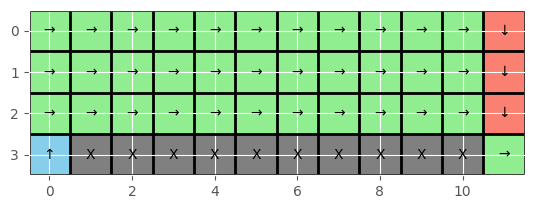

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      




In [13]:
env = gym.make("CliffWalking-v0")
gamma = 0.99
theta = 1e-10
policy, V = value_iteration(env, gamma, theta)

# Plotting the optimal policy and value function
plot_policy2(policy, V, (4, 12))
# Optimal Route
optimal_route_2d = simulate_optimal_route_2d(policy, env, (4, 12))
print("Optimal Route (2D Array):")
for row in optimal_route_2d:
    print(" ".join(row))

print("\n")

## Different vales of γ and θ

#Try out how your implementation responds to different values of discount factor γ, e.g., γ = 1, and the threshold θ.

## VALUE ITERATION ALGO DIFFERENT VALUES


Gamma: 1, Theta: 1e-10
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X →

Optimal Value Function:
-14.00 -13.00 -12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00
-13.00 -12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00
-12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00  -1.00
-13.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  -1.00


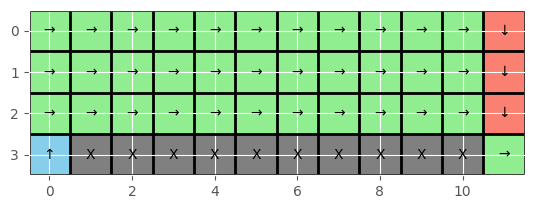

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 1, Theta: 0.0001
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→

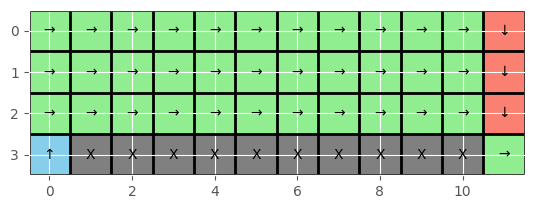

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 1, Theta: 0.01
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ →

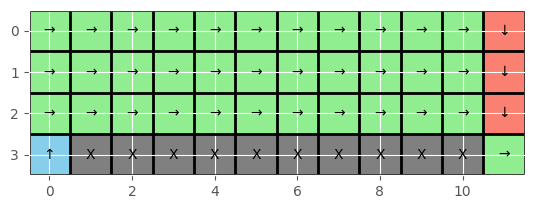

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 0.99, Theta: 1e-10
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓

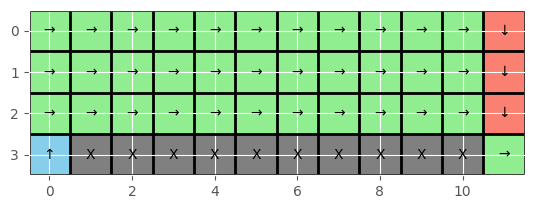

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 0.99, Theta: 0.0001
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → 

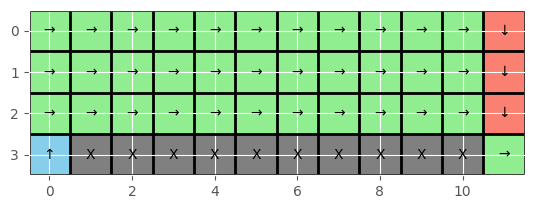

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 0.99, Theta: 0.01
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓


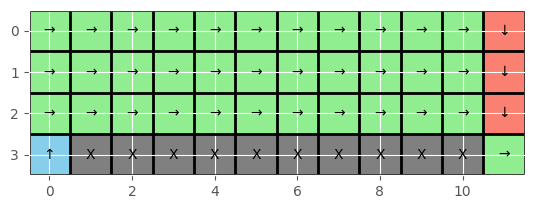

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 0.9, Theta: 1e-10
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓


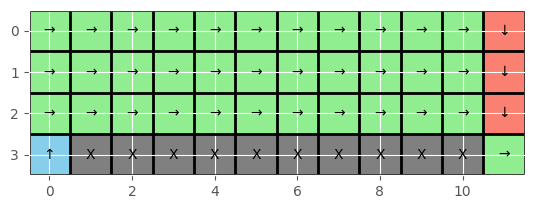

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 0.9, Theta: 0.0001
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓

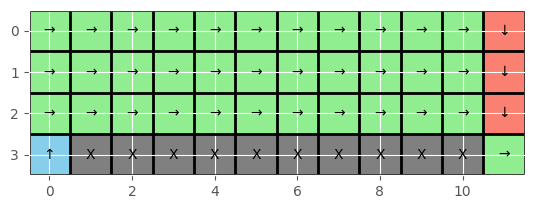

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 0.9, Theta: 0.01
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→

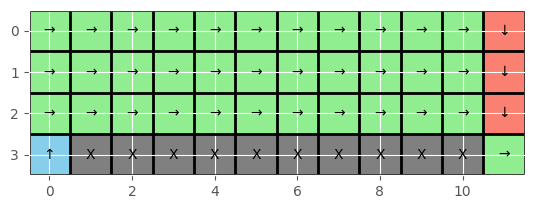

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 0.7, Theta: 1e-10
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓


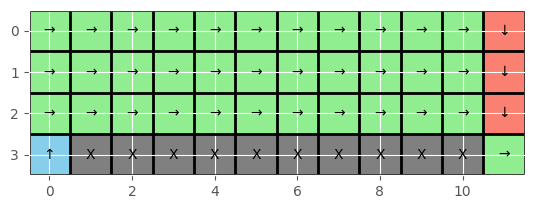

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 0.7, Theta: 0.0001
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓

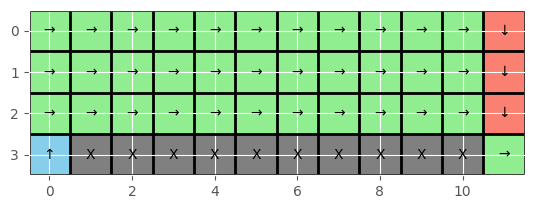

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      



Gamma: 0.7, Theta: 0.01
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→

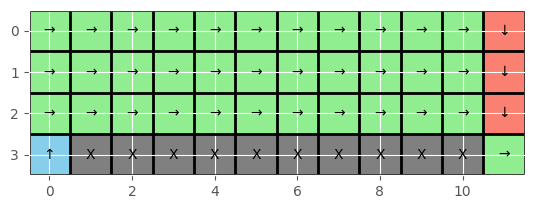

Current state: 36, Action: 0, Next state: 24, Done: False
Current state: 24, Action: 1, Next state: 25, Done: False
Current state: 25, Action: 1, Next state: 26, Done: False
Current state: 26, Action: 1, Next state: 27, Done: False
Current state: 27, Action: 1, Next state: 28, Done: False
Current state: 28, Action: 1, Next state: 29, Done: False
Current state: 29, Action: 1, Next state: 30, Done: False
Current state: 30, Action: 1, Next state: 31, Done: False
Current state: 31, Action: 1, Next state: 32, Done: False
Current state: 32, Action: 1, Next state: 33, Done: False
Current state: 33, Action: 1, Next state: 34, Done: False
Current state: 34, Action: 1, Next state: 35, Done: False
Current state: 35, Action: 2, Next state: 47, Done: True
Reached the goal!
Optimal Route (2D Array):
                       
                       
→ → → → → → → → → → → G
↑                      




In [14]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming the necessary functions like value_iteration, plot_policy2, and simulate_optimal_route_2d are defined

def main():
    env = gym.make("CliffWalking-v0")
    
    gammas = [1, 0.99, 0.9, 0.7]  # Different values for gamma
    thetas = [1e-10, 1e-4, 1e-2]  # Different values for theta

    for gamma in gammas:
        for theta in thetas:
            policy, V = value_iteration(env, gamma, theta)

            print(f"\nGamma: {gamma}, Theta: {theta}")
            
            # Plotting the optimal policy and value function
            plot_policy2(policy, V, (4, 12))

            # Optimal Route
            optimal_route_2d = simulate_optimal_route_2d(policy, env, (4, 12))
            print("Optimal Route (2D Array):")
            for row in optimal_route_2d:
                print(" ".join(row))

            print("\n")

if __name__ == "__main__":
    main()


## POLICY ITERATION DIFFRENT VALUES


Gamma: 1, Theta: 1e-10
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


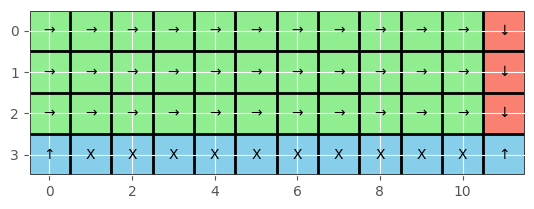

Optimal Value Function:
-14.00 -13.00 -12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00
-13.00 -12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00
-12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00  -1.00
-13.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 1, Theta: 0.0001
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


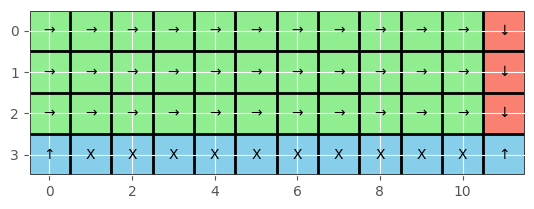

Optimal Value Function:
-14.00 -13.00 -12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00
-13.00 -12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00
-12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00  -1.00
-13.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 1, Theta: 0.01
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


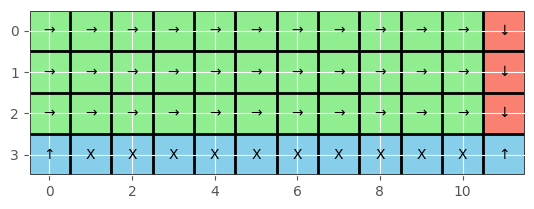

Optimal Value Function:
-14.00 -13.00 -12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00
-13.00 -12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00
-12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00  -1.00
-13.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 0.99, Theta: 1e-10
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


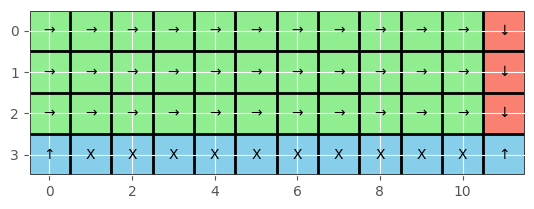

Optimal Value Function:
-13.13 -12.25 -11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97
-12.25 -11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97  -1.99
-11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97  -1.99  -1.00
-12.25   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 0.99, Theta: 0.0001
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


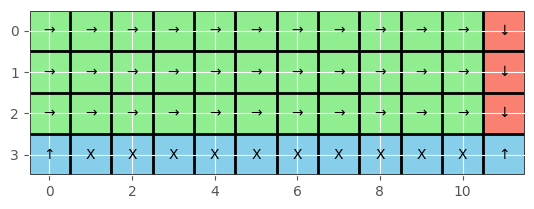

Optimal Value Function:
-13.13 -12.25 -11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97
-12.25 -11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97  -1.99
-11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97  -1.99  -1.00
-12.25   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 0.99, Theta: 0.01
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


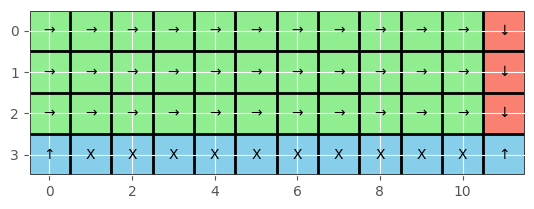

Optimal Value Function:
-13.13 -12.25 -11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97
-12.25 -11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97  -1.99
-11.36 -10.47  -9.56  -8.65  -7.73  -6.79  -5.85  -4.90  -3.94  -2.97  -1.99  -1.00
-12.25   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 0.9, Theta: 1e-10
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


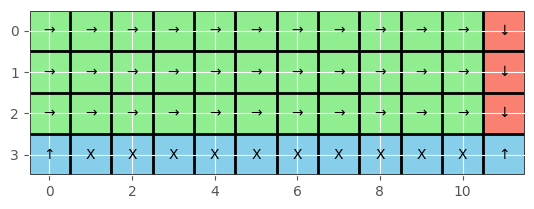

Optimal Value Function:
 -7.71  -7.46  -7.18  -6.86  -6.51  -6.13  -5.70  -5.22  -4.69  -4.10  -3.44  -2.71
 -7.46  -7.18  -6.86  -6.51  -6.13  -5.70  -5.22  -4.69  -4.10  -3.44  -2.71  -1.90
 -7.18  -6.86  -6.51  -6.13  -5.70  -5.22  -4.69  -4.10  -3.44  -2.71  -1.90  -1.00
 -7.46   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 0.9, Theta: 0.0001
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


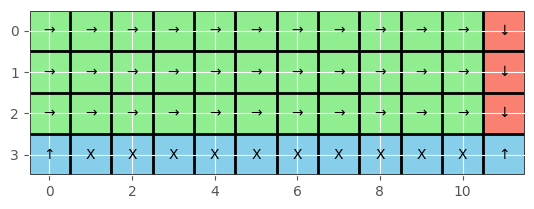

Optimal Value Function:
 -7.71  -7.46  -7.18  -6.86  -6.51  -6.13  -5.70  -5.22  -4.69  -4.10  -3.44  -2.71
 -7.46  -7.18  -6.86  -6.51  -6.13  -5.70  -5.22  -4.69  -4.10  -3.44  -2.71  -1.90
 -7.18  -6.86  -6.51  -6.13  -5.70  -5.22  -4.69  -4.10  -3.44  -2.71  -1.90  -1.00
 -7.46   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 0.9, Theta: 0.01
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


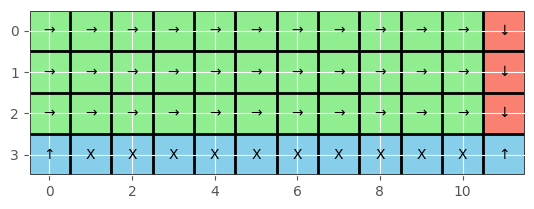

Optimal Value Function:
 -7.71  -7.46  -7.18  -6.86  -6.51  -6.13  -5.70  -5.22  -4.69  -4.10  -3.44  -2.71
 -7.46  -7.18  -6.86  -6.51  -6.13  -5.70  -5.22  -4.69  -4.10  -3.44  -2.71  -1.90
 -7.18  -6.86  -6.51  -6.13  -5.70  -5.22  -4.69  -4.10  -3.44  -2.71  -1.90  -1.00
 -7.46   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 0.7, Theta: 1e-10
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


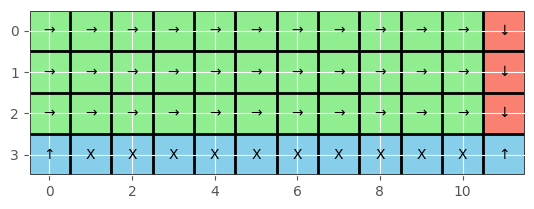

Optimal Value Function:
 -3.31  -3.30  -3.29  -3.27  -3.24  -3.20  -3.14  -3.06  -2.94  -2.77  -2.53  -2.19
 -3.30  -3.29  -3.27  -3.24  -3.20  -3.14  -3.06  -2.94  -2.77  -2.53  -2.19  -1.70
 -3.29  -3.27  -3.24  -3.20  -3.14  -3.06  -2.94  -2.77  -2.53  -2.19  -1.70  -1.00
 -3.30   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 0.7, Theta: 0.0001
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


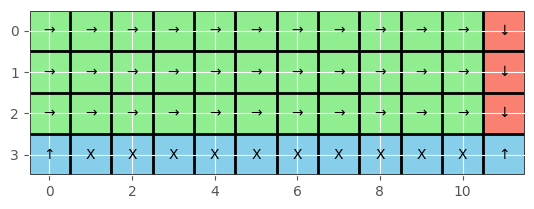

Optimal Value Function:
 -3.31  -3.30  -3.29  -3.27  -3.24  -3.20  -3.14  -3.06  -2.94  -2.77  -2.53  -2.19
 -3.30  -3.29  -3.27  -3.24  -3.20  -3.14  -3.06  -2.94  -2.77  -2.53  -2.19  -1.70
 -3.29  -3.27  -3.24  -3.20  -3.14  -3.06  -2.94  -2.77  -2.53  -2.19  -1.70  -1.00
 -3.30   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      

Gamma: 0.7, Theta: 0.01
Optimal Policy (Visual Representation):
Policy as 2D Array of Symbols:
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ X X X X X X X X X X ↑


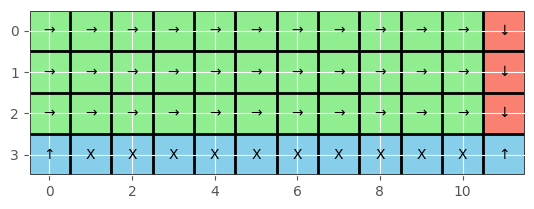

Optimal Value Function:
 -3.31  -3.30  -3.29  -3.27  -3.24  -3.20  -3.14  -3.06  -2.94  -2.77  -2.53  -2.19
 -3.30  -3.29  -3.27  -3.24  -3.20  -3.14  -3.06  -2.94  -2.77  -2.53  -2.19  -1.70
 -3.29  -3.27  -3.24  -3.20  -3.14  -3.06  -2.94  -2.77  -2.53  -2.19  -1.70  -1.00
 -3.30   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Optimal Route (Simulated Policy):
Optimal Route:
                       
                       
→ → → → → → → → → → → ↓
↑                      


In [15]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# [Include all your defined functions here, such as policy_evaluation, policy_improvement, etc.]

if __name__ == "__main__":
    env = gym.make("CliffWalking-v0")
    shape = (4, 12)  # Shape of the environment grid

    gammas = [1, 0.99, 0.9, 0.7]  # Different values for gamma
    thetas = [1e-10, 1e-4, 1e-2]  # Different values for theta

    for gamma in gammas:
        for theta in thetas:
            optimal_policy, optimal_V = policy_iteration(env, gamma, theta)
            
            print(f"\nGamma: {gamma}, Theta: {theta}")
            print("Optimal Policy (Visual Representation):")
            plot_policy(optimal_policy, shape)

            print("Optimal Value Function:")
            for row in np.reshape(optimal_V, shape):
                print(" ".join(f"{value:6.2f}" for value in row))

            print("Optimal Route (Simulated Policy):")
            plot_simulated_policy(optimal_policy, env, shape)


## Analysis of Value Iteration and Policy Iteration

### Are the optimal policies and value functions identical for the two algorithms?
Based on the given outputs, the optimal policies and value functions appear to be identical for both algorithms when the discount factor gamma is 1. This indicates that for a deterministic environment, both algorithms converge to the same policy and value function when they are allowed to converge fully.

### How do the policies and value functions change during learning?
During the learning process:
- **Value iteration** updates the value function based on the max-operator over the Bellman equation in each iteration until the change in the value function is less than the threshold theta.
- **Policy iteration** involves two steps: policy evaluation, where the value function is updated until convergence given the current policy, and policy improvement, where the policy is updated to be greedy with respect to the current value function.

The value function changes at each iteration, reflecting the expected return from each state under the current policy. Both algorithms iterate to refine the policy and value function, but policy iteration includes explicit policy evaluation and improvement steps, which can lead to faster convergence in terms of the number of iterations but may involve more computation per iteration.

### Comparing Convergence
The convergence plot provided indicates that value iteration has a steady and predictable convergence pattern, with delta (the maximum change in the value function across all states from one iteration to the next) decreasing exponentially due to the discount factor.

Policy iteration's delta values are larger, which might suggest that it is making more significant changes to the policy in the early iterations. However, the final deltas for policy iteration drop to zero, indicating convergence to an optimal policy.

The convergence rate of value iteration is affected by both gamma and theta:
- **Higher gamma values** (close to 1) give more importance to future rewards, leading to a more far-sighted policy.
- **Lower theta values** require the value function to converge more closely to the true value before stopping, which can increase the number of iterations needed.

For policy iteration, the changes in the value function are more substantial between iterations, but it typically converges in fewer iterations compared to value iteration.

### Conclusion
Both algorithms converge to the same policy and value function, given sufficient time to iterate. Value iteration's convergence rate is more consistent, while policy iteration makes larger updates less frequently but may converge in fewer iterations. The choice between the two algorithms may depend on the specific requirements of computational resources and the problem at hand.


Value Iteration: Iteration 0, Delta: 1.99
Value Iteration: Iteration 1, Delta: 0.99
Value Iteration: Iteration 2, Delta: 0.9801
Value Iteration: Iteration 3, Delta: 0.9702989999999998
Value Iteration: Iteration 4, Delta: 0.9605960100000002
Value Iteration: Iteration 5, Delta: 0.9509900498999997
Value Iteration: Iteration 6, Delta: 0.9414801494010003
Value Iteration: Iteration 7, Delta: 0.93206534790699
Value Iteration: Iteration 8, Delta: 0.9227446944279203
Value Iteration: Iteration 9, Delta: 0.9135172474836413
Value Iteration: Iteration 10, Delta: 0.9043820750088045
Value Iteration: Iteration 11, Delta: 0.895338254258716
Value Iteration: Iteration 12, Delta: 0.88638487171613
Value Iteration: Iteration 13, Delta: 0.8775210229989678
Value Iteration: Iteration 14, Delta: 0
Policy Iteration: Iteration 0, Delta: 1041.5530671298095
Policy Iteration: Iteration 1, Delta: 88.62884046590395
Policy Iteration: Iteration 2, Delta: 87.74235815271601
Policy Iteration: Iteration 3, Delta: 86.8647387

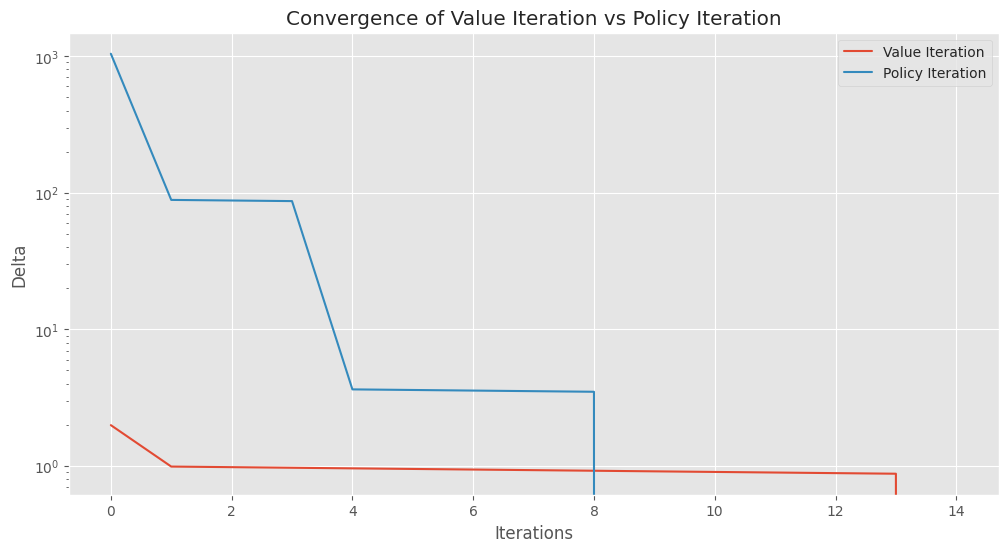

In [75]:
import numpy as np
import gym
import matplotlib.pyplot as plt


def convergence_tracking_value_iteration(env, gamma, theta):
    V = np.zeros(env.nS)
    deltas = []  # To track changes in value function
    iteration = 0

    while True:
        delta = 0
        for s in range(env.nS):
            A = one_step_lookahead(env, s, V, gamma)
            best_action_value = np.max(A)
            delta = max(delta, np.abs(best_action_value - V[s]))
            V[s] = best_action_value
        deltas.append(delta)
        print(f"Value Iteration: Iteration {iteration}, Delta: {delta}")
        iteration += 1
        if delta < theta or iteration > 1000:  # Added iteration limit for safety
            break
    return deltas

def convergence_tracking_policy_iteration(env, gamma, theta):
    policy = np.ones([env.nS, env.nA]) / env.nA
    deltas = []  # To track changes in value function
    iteration = 0

    while True:
        V = policy_evaluation(policy, env, gamma, theta)
        new_policy = policy_improvement(V, env, gamma)
        delta = np.max(np.abs(V - policy_evaluation(new_policy, env, gamma, theta)))
        deltas.append(delta)
        print(f"Policy Iteration: Iteration {iteration}, Delta: {delta}")
        iteration += 1
        if np.all(policy == new_policy) or iteration > 1000:  # Added iteration limit for safety
            break
        policy = new_policy
    return deltas

# Initialize environment
env = gym.make("CliffWalking-v0")
gamma = 0.99
theta = 1e-4  # Adjusted for quicker convergence

# Get convergence data
value_iteration_deltas = convergence_tracking_value_iteration(env, gamma, theta)
policy_iteration_deltas = convergence_tracking_policy_iteration(env, gamma, theta)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(value_iteration_deltas, label='Value Iteration')
plt.plot(policy_iteration_deltas, label='Policy Iteration')
plt.xlabel('Iterations')
plt.ylabel('Delta')
plt.title('Convergence of Value Iteration vs Policy Iteration')
plt.yscale('log')  # Log scale for better visualization
plt.legend()
plt.grid(True)
plt.show()


## Convergence of Value Iteration vs Policy Iteration Plot

### Observations:

- **Value Iteration Convergence:**
  - Shows a consistent exponential decay in delta, which is characteristic of the value iteration process.
  - As the iterations progress, the change in value function (delta) decreases, converging towards zero.
  - Convergence is reached at iteration 14, where the delta becomes zero, indicating no further improvement in the value function is possible—suggesting optimality.

- **Policy Iteration Convergence:**
  - Starts with a significantly high delta compared to value iteration, indicating substantial changes in the value function at the beginning.
  - The delta decreases dramatically after the initial iterations and reaches zero at iteration 9, at which point the policy has converged.
  - The rapid decline to zero suggests that once a near-optimal policy is identified, policy iteration refines it quickly to the optimal policy.

### Comparison:

- Policy iteration seems to reach convergence faster than value iteration in terms of the number of iterations.
- The initial changes in the policy iteration are much larger, which might involve more computational effort per iteration compared to value iteration.
- Value iteration shows a smooth convergence, while policy iteration has a steep drop to zero once it's close to the optimal policy.

### Implications:

- If computational resources per iteration are a concern, value iteration may be more suitable due to its smoother convergence.
- For scenarios where rapid convergence to an optimal policy is crucial and computational resources are abundant, policy iteration may be the preferred method.
- This plot demonstrates the trade-offs between the two algorithms and can guide the choice of algorithm based on the specific needs of the problem and available computational resources.

In conclusion, both algorithms ultimately converge to an optimal policy, but they differ in their convergence patterns and computational demands per iteration.


## 5 Implement temporal-difference learning algorithms

# FIRST DEFINE FUNCTIONS AND PLOTTING FUNCTIONS

In [17]:
# Creates an epsilon-greedy policy based on a given Q-function and epsilon.
# Returns a function that takes the observation/state as an argument and returns
#   the probabilities for each action in the form of a numpy array of length nA.

def make_epsilon_greedy_policy(Q, epsilon, nA):

    def policy_fn(observation):
        # Extract the state part of the observation

        # Problem = 'observation' is a tuple the first time the program is accessed, but not the second time it is an integer
        # Determine if the observation is a tuple with additional info
        if isinstance(observation, tuple) and len(observation) > 1:
            state = observation[0]  # Extract the state if it's a tuple
        else:
            state = observation  # Use the observation directly if it's an integer

        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        #Debug
        #print ("Current observation used:", observation)
        #print ("Current state used for Q-table:", state)
        #End debug
        best_action = np.argmax(Q[state])
        pi[best_action] += (1.0 - epsilon)
        return pi

    return policy_fn

In [18]:
%%time

# Parameters
verbose_val = False  # Set to true to debug

def generate_episode(policy, verbose=verbose_val):
    episode = []
    curr_state = env.reset()
    probs = policy(curr_state)
    action = np.random.choice(np.arange(len(probs)), p=probs)
    number_steps = 0   # Debug

    while True:
        if verbose:
            print ("Current position:", curr_state)
            #print (env.render())

        next_obs, reward, is_terminal, truncated, _ = env.step(action)
        number_steps += 1   # Debug

        if verbose:
            #print ("Action taken:", actions[action])
            print ("Next observation:", next_obs)
            print ("Reward received:", reward)
            print ("Truncated by max steps:", truncated)
            print ("Terminal state:", is_terminal)
            #print (env.render())
            print ("-"*20)
        episode.append((curr_state, action, reward))
        #Debug
        # if a lot of steps
        #if (number_steps + 1) % 10000 == 0:
        #    frame = env.render()
        #    clear_output(wait=True)   # clear previous image
        #    plt.imshow(frame)
        #    plt.show()
        # if not very many
        frame = env.render()
        clear_output(wait=True)   # clear previous image
        plt.imshow(frame)
        plt.show()
        #End debug

        # Pick the next action
        next_probs = policy(next_state)
        next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)

        curr_state = next_obs
        action = next_action

        if (is_terminal):
            break

    return episode

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
# Define a plotting function
# start_plot_from   # Plot the episode length over time starting from the Xth episode

def plot_episode_stats(episode_lengths, episode_rewards, start_plot_from, smoothing_window, policy, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(8,4))
    plt.plot(episode_lengths, label=policy)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    # Explicitly adding a legend to make the label appear
    plt.legend()
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode length over time starting from the Xth episode
    fig2 = plt.figure(figsize=(8,4))
    plt.plot(episode_lengths[start_plot_from-1:], label=policy)  # Adjust start_plot_from-1 to your specific needs
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title(f"Episode Length over Time (from {start_plot_from}th Episode)")
    # Explicitly adding a legend to make the label appear
    plt.legend()
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot the episode reward over time
    fig3 = plt.figure(figsize=(8,4))
    rewards_smoothed = pd.Series(episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed, label=policy)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    # Explicitly adding a legend to make the label appear
    plt.legend()
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    # Plot time steps and episode number
    fig4 = plt.figure(figsize=(8,4))
    plt.plot(np.cumsum(episode_lengths), np.arange(len(episode_lengths)), label=policy)
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Number of completed episodes over total time steps")
    # Explicitly adding a legend to make the label appear
    plt.legend()
    if noshow:
        plt.close(fig4)
    else:
        plt.show(fig4)

    return fig1, fig2, fig3, fig4

In [20]:
# Plotting function that compares the 2 different methods

def compare_two_episode_stats(method1_lengths, method2_lengths, method1_rewards, method2_rewards,
                          start_plot_from, smoothing_window, policy1, policy2, noshow=False):
    # Create a figure for episode lengths over time
    fig1 = plt.figure(figsize=(8, 4))
    plt.plot(method1_lengths[start_plot_from-1:], label=policy1)  # Start from the specific episode
    plt.plot(method2_lengths[start_plot_from-1:], label=policy2)  # Start from the specific episode
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title(f"Episode Length over Time (from {start_plot_from}th Episode)")
    plt.legend()
    if not noshow:
        plt.show(fig1)

    # Create a figure for smoothed rewards over time
    fig2 = plt.figure(figsize=(8, 4))
    method1_rewards_smoothed = pd.Series(method1_rewards[start_plot_from-1:]).rolling(smoothing_window, min_periods=smoothing_window).mean()
    method2_rewards_smoothed = pd.Series(method2_rewards[start_plot_from-1:]).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(method1_rewards_smoothed, label=policy1)
    plt.plot(method2_rewards_smoothed, label=policy2)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title(f"Episode Reward over Time (Smoothed over window size {smoothing_window} and from {start_plot_from}th Episode)")
    plt.legend()
    if not noshow:
        plt.show(fig2)


    # Create a figure for the number of completed episodes over total time steps
    fig3 = plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(method1_lengths), np.arange(len(method1_lengths)), label=policy1)
    plt.plot(np.cumsum(method2_lengths), np.arange(len(method2_lengths)), label=policy2)
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Number of completed episodes over total time steps")
    plt.legend()
    if not noshow:
        plt.show(fig3)

    return fig1, fig2, fig3

In [21]:
# Plotting function that compares the 3 different methods

def compare_three_episode_stats(sarsa_lengths, q_learning_lengths, exp_sarsa_lengths,
                                sarsa_rewards, q_learning_rewards, exp_sarsa_rewards,
                                start_plot_from, smoothing_window,  noshow=False):

    # Create a figure for episode lengths over time
    fig1 = plt.figure(figsize=(8, 4))
    plt.plot(sarsa_lengths[start_plot_from-1:], label='SARSA')
    plt.plot(q_learning_lengths[start_plot_from-1:], label='Q-Learning')
    plt.plot(exp_sarsa_lengths[start_plot_from-1:], label='Expected SARSA')
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title(f"Episode Length over Time (from {start_plot_from}th Episode)")
    plt.legend()
    plt.show(fig1)

    # Create a figure for smoothed rewards over time
    fig2 = plt.figure(figsize=(8, 4))
    sarsa_rewards_smoothed = pd.Series(sarsa_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    q_learning_rewards_smoothed = pd.Series(q_learning_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    exp_sarsa_rewards_smoothed = pd.Series(exp_sarsa_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(sarsa_rewards_smoothed, label='SARSA')
    plt.plot(q_learning_rewards_smoothed, label='Q-Learning')
    plt.plot(exp_sarsa_rewards_smoothed, label='Expected SARSA')
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title(f"Episode Reward over Time (Smoothed over window size {smoothing_window})")
    plt.legend()
    plt.show(fig2)

    # Number of completed episodes over total time steps
    fig3 = plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(sarsa_lengths), np.arange(len(sarsa_lengths)), label='SARSA')
    plt.plot(np.cumsum(q_learning_lengths), np.arange(len(q_learning_lengths)), label='Q-Learning')
    plt.plot(np.cumsum(exp_sarsa_lengths), np.arange(len(exp_sarsa_lengths)), label='Expected SARSA')
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Number of completed episodes over total time steps")
    plt.legend()
    if not noshow:
        plt.show(fig3)

    return fig1, fig2, fig3

In [22]:
# Plotting function that compares the 4 different methods

def compare_episode_stats_all(sarsa_lengths, q_learning_lengths, exp_sarsa_lengths, double_q_lengths,
                              sarsa_rewards, q_learning_rewards, exp_sarsa_rewards, double_q_rewards,
                              start_plot_from=10, smoothing_window=10, noshow=False):
    # Episode lengths over time
    fig1 = plt.figure(figsize=(8, 4))
    plt.plot(sarsa_lengths[start_plot_from-1:], label='SARSA')
    plt.plot(q_learning_lengths[start_plot_from-1:], label='Q-Learning')
    plt.plot(exp_sarsa_lengths[start_plot_from-1:], label='Expected SARSA')
    plt.plot(double_q_lengths[start_plot_from-1:], label='Double Q-Learning')
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title(f"Episode Length over Time (from {start_plot_from}th Episode)")
    plt.legend()
    if not noshow:
        plt.show(fig1)

    # Smoothed rewards over time
    fig2 = plt.figure(figsize=(8, 4))
    sarsa_rewards_smoothed = pd.Series(sarsa_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    q_learning_rewards_smoothed = pd.Series(q_learning_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    exp_sarsa_rewards_smoothed = pd.Series(exp_sarsa_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    double_q_rewards_smoothed = pd.Series(double_q_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(sarsa_rewards_smoothed, label='SARSA')
    plt.plot(q_learning_rewards_smoothed, label='Q-Learning')
    plt.plot(exp_sarsa_rewards_smoothed, label='Expected SARSA')
    plt.plot(double_q_rewards_smoothed, label='Double Q-Learning')
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title(f"Episode Reward over Time (Smoothed over window size {smoothing_window})")
    plt.legend()
    if not noshow:
        plt.show(fig2)

    # Number of completed episodes over total time steps
    fig3 = plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(sarsa_lengths), np.arange(len(sarsa_lengths)), label='SARSA')
    plt.plot(np.cumsum(q_learning_lengths), np.arange(len(q_learning_lengths)), label='Q-Learning')
    plt.plot(np.cumsum(exp_sarsa_lengths), np.arange(len(exp_sarsa_lengths)), label='Expected SARSA')
    plt.plot(np.cumsum(double_q_lengths), np.arange(len(double_q_lengths)), label='Double Q-Learning')
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Number of completed episodes over total time steps")
    plt.legend()
    if not noshow:
        plt.show(fig3)

    return fig1, fig2, fig3

## Implement SARSA

In [23]:
#Paramters
discount_fact_sarsa = 1.0
alpha_val_sarsa = 0.5
epsilon_sarsa = 0.1
num_episodes_sarsa = 1000   # number of episodes
display_number_episodes_sarsa = 0   # Number of episodes to show
# Initialize environment
env = gym.make("CliffWalking-v0")


def sarsa(env, num_episodes_sarsa, discount_factor=discount_fact_sarsa, alpha=alpha_val_sarsa, epsilon=epsilon_sarsa):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float between 0 and 1.

    Returns:
        A tuple (Q, sarsa_stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        sarsa_stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics. Initialize statistics
    sarsa_stats = {
        'episode_lengths': np.zeros(num_episodes_sarsa),
        'episode_rewards': np.zeros(num_episodes_sarsa)
    }

    # For calculating the number of episodes to show
    show_episodes_sarsa = True
    if display_number_episodes_sarsa == 0:
        show_episodes_sarsa = False
    else:
        interval_epi = max(1, num_episodes_sarsa // display_number_episodes_sarsa)

    # The policy we're following
    policy_sarsa = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i_episode in range(num_episodes_sarsa):

        # Reset the environment and pick the first action
        state = env.reset()
        #print ('state = ', state)    #Debug
        probs = policy_sarsa(state)
        #print ('probs = ', probs)   #Debug
        action = np.random.choice(np.arange(len(probs)), p=probs)    # Randomly choose one action, ie one way to go (up, left, etc)
        #print ('action = ', action)   #Debug
        t = 0   # Initialize timestep t

        # Updating Q-values Online at Each Step
        # The interaction is with the environment step-by-step.
        # At each step, the Q-values are immediately updated based on the latest action and reward.
        # This is the Temporal-Difference learning method, where the update is done directly after the next time step.
        for t in itertools.count():     # itertools.count() creates an infinite iterator
            # Take a step
            next_state, reward, is_terminal, is_truncated,_ = env.step(action)

            # Show Agent movements at specific intervals
            if show_episodes_sarsa:
                if i_episode % interval_epi == 0:  # Check if this episode should be displayed
                    frame = env.render()
                    clear_output(wait=True)   # clear previous image
                    plt.title(f"Episode: {i_episode + 1}/{num_episodes_sarsa}")  # Display the episode number
                    plt.imshow(frame)
                    #plt.pause(0.1)  # Adjust the pause time as needed for smooth viewing
                    plt.show()

            # Pick the next action
            next_probs = policy_sarsa(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)

            # Problem as state is a tuple the first time it is accessed, but an integer the following
            # Extract the state part if it's a tuple with additional info
            if isinstance(state, tuple):
                state = state[0]
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            sarsa_stats['episode_rewards'][i_episode] += reward
            sarsa_stats['episode_lengths'][i_episode] = t

            if is_terminal:
                break

            state = next_state
            action = next_action
            t += 1     # Increment timestep

    return Q, sarsa_stats

In [24]:
%%time
Q_sarsa, sarsa_stats = sarsa(env, num_episodes_sarsa)

# Collect stats from SARSA for comparison
sarsa_episode_lengths = sarsa_stats['episode_lengths']
sarsa_episode_rewards = sarsa_stats['episode_rewards']

CPU times: total: 500 ms
Wall time: 907 ms


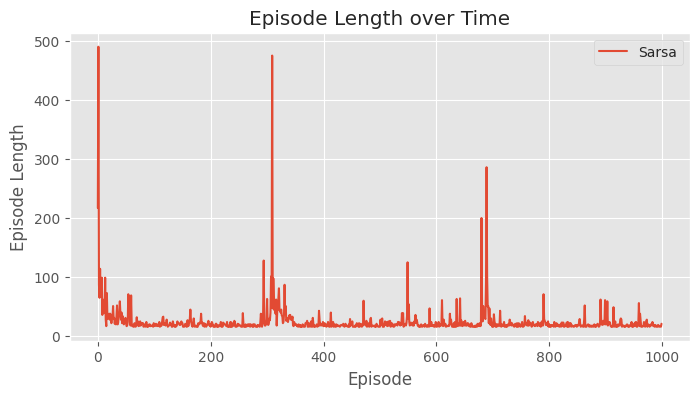

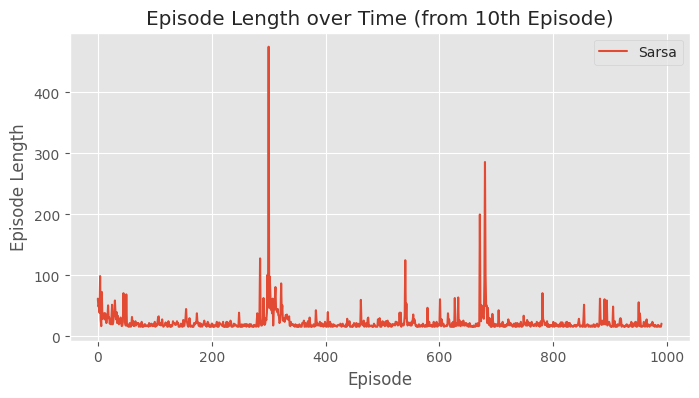

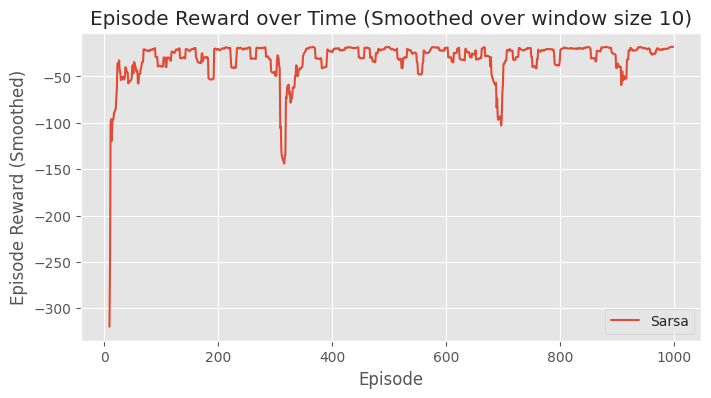

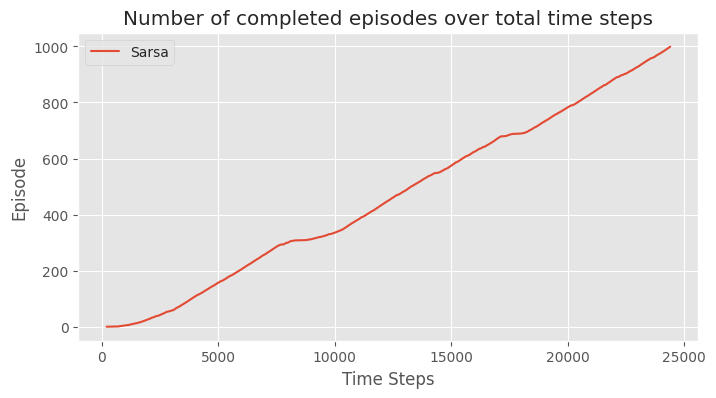

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [25]:
# Plotting episodes

# Parameter
start_plot_from = 10    # Skip the first episodes in graph
smoothing_window = 10

plot_episode_stats(sarsa_stats['episode_lengths'], sarsa_stats['episode_rewards'], start_plot_from, smoothing_window=smoothing_window, policy='Sarsa')

In [26]:
# get greedy policy from Q
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])

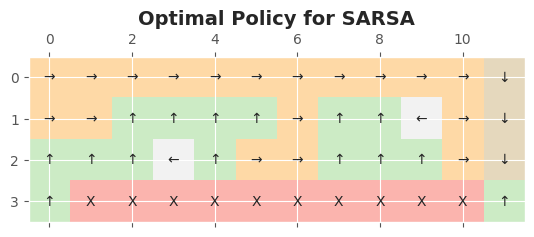

In [27]:
# Plot the optimal policy

# Define the shape of your environment's grid
grid_shape = (4, 12)

# Create opt_policy
opt_policy_sarsa = np.reshape(policy_sarsa, (4, 12))

# Create a function to plot the policy
def plot_policy(policy_sarsa, shape):
    # Define the grid
    #grid = np.argmax(policy_sarsa, axis=1).reshape(shape)
    grid = policy_sarsa.reshape(shape)

    # Create a figure and axis
    fig, ax = plt.subplots()
    ax.matshow(grid, cmap=plt.cm.Pastel1)

    # Define the symbols for each action (up, right, down, left)
    actions = {0: '↑', 1: '→', 2: '↓', 3: '←', -1: 'X'}   # 'X' is the cliff

    # Annotate the grid with action symbols
    for i in range(shape[0]):
        for j in range(shape[1]):
            #action_grid = actions[grid[i, j]]
            #ax.text(j, i, action_grid, va='center', ha='center')
            action_symbol = actions.get(grid[i, j], '?')  # '?' for unexpected numbers
            ax.text(j, i, action_symbol, va='center', ha='center')

    plt.title("Optimal Policy for SARSA", fontsize=14, weight='bold')
    plt.show()

# Plot the policy
policy_array = np.array(np.reshape(policy_sarsa, (4, 12)))
plot_policy(policy_array, grid_shape)

In [28]:
# Print Optimal Value Function of SARSA

optimal_value_function_sarsa = np.reshape(v_sarsa, (4, 12))  # 'v' is optimal value function array

print("Optimal Value Function SARSA:")
for row in optimal_value_function_sarsa:
    formatted_row = ' '.join(f"{value:6.2f}" for value in row)  # Adjust formatting as needed
    print(formatted_row)
print("")

Optimal Value Function SARSA:
-20.02 -17.65 -13.82 -12.49 -11.49 -10.27  -9.67 -12.11  -7.59  -5.73  -4.34  -3.07
-18.06 -19.41 -16.31 -17.86 -15.91 -12.64 -16.58 -12.77 -10.62 -13.88  -3.03  -2.00
-19.35 -18.98 -20.18 -23.41 -18.14 -18.27 -17.95 -17.36 -18.31 -14.62  -2.25  -1.00
-20.83   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



## Implement the Q-learning algorithm

In [29]:
#Paramters
discount_fact_Qlearn = 1.0
alpha_val_Qlearn = 0.5
epsilon_Qlearn = 0.1
num_episodes_Qlearn = 1000   # number of episodes
display_number_episodes_Qlearn = 0   # Number of episodes to show

def q_learning(env, num_episodes_Qlearn, discount_factor=discount_fact_Qlearn,
               alpha=alpha_val_Qlearn, epsilon=epsilon_Qlearn):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy while following an epsilon-greedy policy

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.

    Returns:
        A tuple (Q, Qlearn_stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        Qlearn_stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    Qlearn_stats = {
        'episode_lengths': np.zeros(num_episodes_Qlearn),
        'episode_rewards': np.zeros(num_episodes_Qlearn)
    }

    # For calculating the number of episodes to show
    show_episodes_Qlearn = True
    if display_number_episodes_Qlearn == 0:
        show_episodes_Qlearn = False
    else:
        interval_epi = max(1, num_episodes_Qlearn // display_number_episodes_Qlearn)

    # The policy we're following
    policy_qlearn = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i_episode in range(num_episodes_Qlearn):

        # Reset the environment
        state = env.reset()
        t = 0   # Initialize timestep t

        probs = policy_qlearn(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        # One step in the environment
        # Q-Learning algorithm: Off-policy TD control.
        # Finds the optimal greedy policy while following an epsilon-greedy policy
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, is_truncated,_ = env.step(action)

            # Show Agent movements at specific intervals
            if show_episodes_Qlearn:
                if i_episode % interval_epi == 0:  # Check if this episode should be displayed
                    frame = env.render()
                    clear_output(wait=True)   # clear previous image
                    plt.title(f"Episode: {i_episode + 1}/{num_episodes_Qlearn}")  # Display the episode number
                    plt.imshow(frame)
                    #plt.pause(0.1)  # Adjust the pause time as needed for smooth viewing
                    plt.show()

            # Pick the next action
            best_next_action = np.argmax(Q[next_state])

            # Problem as state is a tuple the first time it is accessed, but an integer the following
            # Extract the state part if it's a tuple with additional info
            if isinstance(state, tuple):
                state = state[0]
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            Qlearn_stats['episode_rewards'][i_episode] += reward
            Qlearn_stats['episode_lengths'][i_episode] = t

            if is_terminal:
                break

            state = next_state
            action = best_next_action
            t += 1   # Increment timestep

    return Q, Qlearn_stats

In [30]:
%%time
Q_q_learning, Qlearn_stats = q_learning(env, num_episodes_Qlearn)

# Collect stats from Q-Learning for comparison
q_learning_episode_lengths = Qlearn_stats['episode_lengths']
q_learning_episode_rewards = Qlearn_stats['episode_rewards']

CPU times: total: 93.8 ms
Wall time: 296 ms


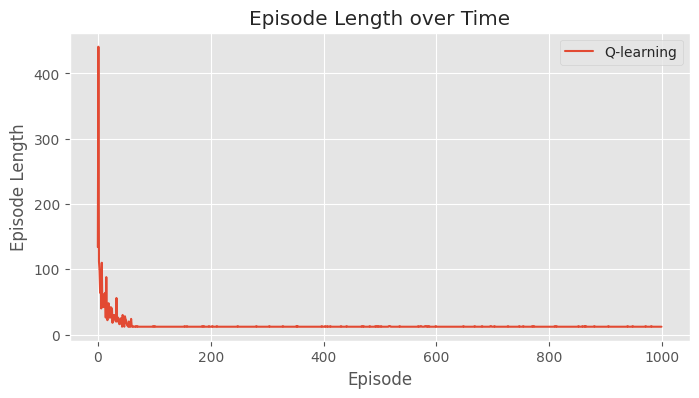

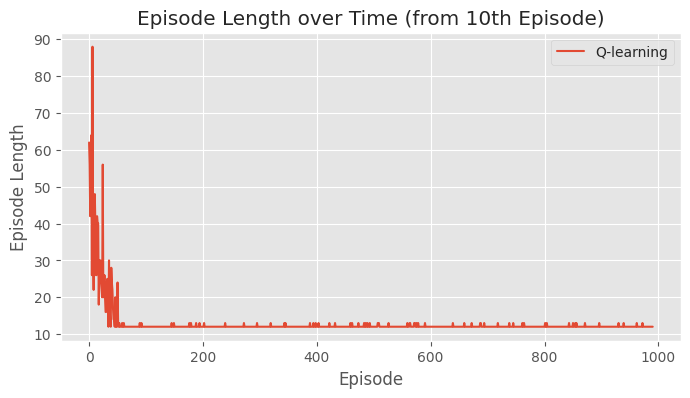

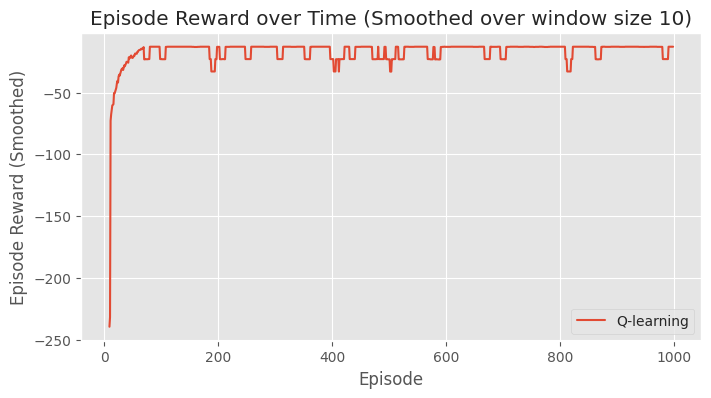

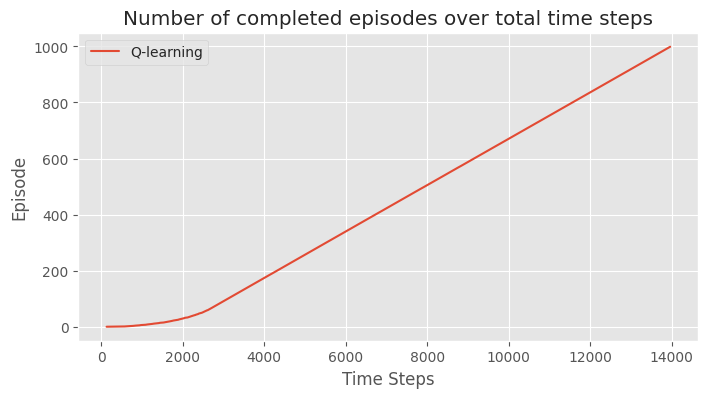

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [31]:
# Plotting episodes

# Parameter
start_plot_from = 10    # Skip the first episodes in graph
smoothing_window = 10

plot_episode_stats(Qlearn_stats['episode_lengths'], Qlearn_stats['episode_rewards'],
                   start_plot_from, smoothing_window=smoothing_window, policy='Q-learning')

In [32]:
# get greedy policy from Q
policy_qlearn = np.array([np.argmax(Q_q_learning[key]) if key in Q_q_learning else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v_q_learning = ([np.max(Q_q_learning[key]) if key in Q_q_learning else 0 for key in np.arange(48)])

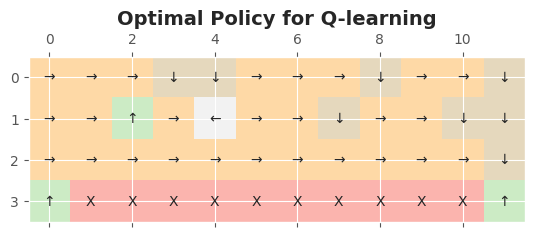

In [33]:
# Plot the optimal policy

# Define the shape of your environment's grid
grid_shape = (4, 12)

# Create opt_policy
opt_policy_qlearn = np.reshape(policy_qlearn, (4, 12))

# Create a function to plot the policy
def plot_policy(policy_qlearn, shape):
    # Define the grid
    #grid = np.argmax(policy, axis=1).reshape(shape)
    grid = policy_qlearn.reshape(shape)

    # Create a figure and axis
    fig, ax = plt.subplots()
    ax.matshow(grid, cmap=plt.cm.Pastel1)

    # Define the symbols for each action (up, right, down, left)
    actions = {0: '↑', 1: '→', 2: '↓', 3: '←', -1: 'X'}   # 'X' is the cliff

    # Annotate the grid with action symbols
    for i in range(shape[0]):
        for j in range(shape[1]):
            #action_grid = actions[grid[i, j]]
            #ax.text(j, i, action_grid, va='center', ha='center')
            action_symbol = actions.get(grid[i, j], '?')  # '?' for unexpected numbers
            ax.text(j, i, action_symbol, va='center', ha='center')

    plt.title("Optimal Policy for Q-learning", fontsize=14, weight='bold')
    plt.show()

# Plot the policy
policy_array = np.array(np.reshape(policy_qlearn, (4, 12)))
plot_policy(policy_array, grid_shape)

In [34]:
optimal_value_function_Qlearn = np.reshape(v_q_learning, (4, 12))  # 'v' is optimal value function array

print("Optimal Value Function Q-learn:")
for row in optimal_value_function_Qlearn:
    formatted_row = ' '.join(f"{value:6.2f}" for value in row)  # Adjust formatting as needed
    print(formatted_row)
print("")

Optimal Value Function Q-learn:
-11.13 -10.63  -9.95  -9.19  -8.47  -7.64  -6.96  -6.18  -5.31  -4.55  -3.71  -2.95
-11.36 -10.78  -9.90  -9.15  -8.31  -7.52  -6.63  -5.76  -4.85  -3.94  -2.98  -2.00
-12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00  -1.00
-13.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



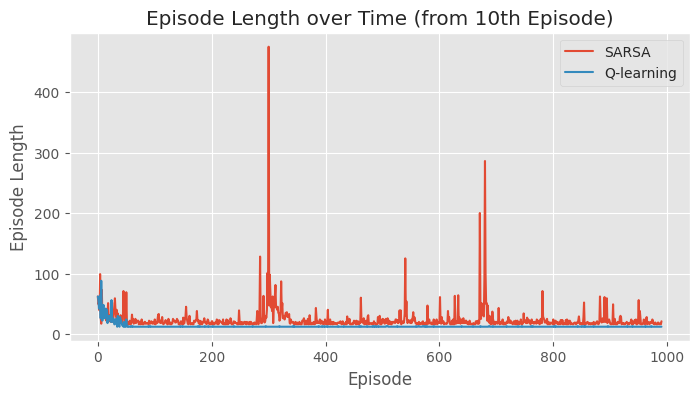

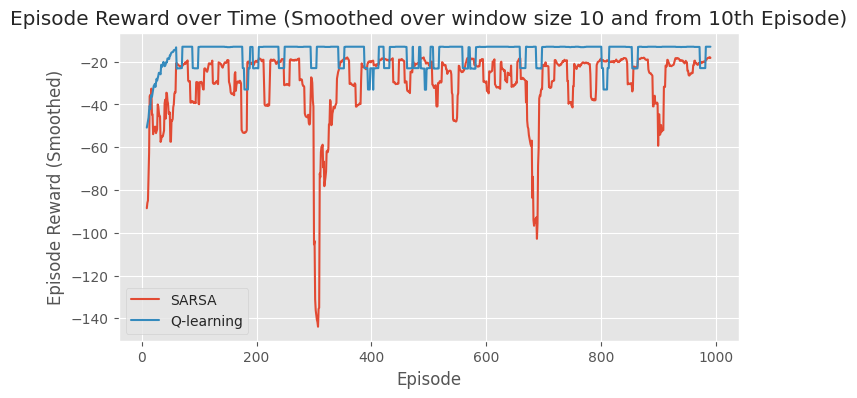

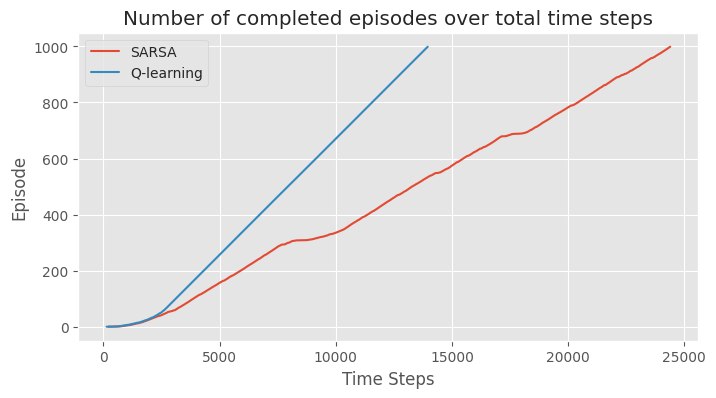

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [35]:
# Compare Episode Lengths
compare_two_episode_stats(sarsa_episode_lengths, q_learning_episode_lengths,
                      sarsa_episode_rewards, q_learning_episode_rewards,
                      start_plot_from=10, smoothing_window=10, policy1='SARSA', policy2='Q-learning')

# Implement the Expected SARSA algorithm

In [36]:
# Paramters
discount_fact_Esarsa = 1.0
alpha_val_Esarsa = 0.5
epsilon_Esarsa = 0.1
num_episodes_Esarsa = 1000   # number of episodes
display_number_episodes_Esarsa = 0   # Number of episodes to show

def expected_sarsa(env, num_episodes, discount_factor=discount_fact_Esarsa, alpha=alpha_val_Esarsa, epsilon=epsilon_Esarsa):
    """
    Expected SARSA algorithm: On-policy TD control. Finds the optimal policy while following an epsilon-greedy policy and considering the expected value over all possible actions.

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.

    Returns:
        A tuple (Q, Esarsa_stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        Esarsa_stats is an object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # The difference in the code compared to Q-learning is
    # Expected Value Calculation: The primary difference is in how the expected_value_next_state is calculated.
    # Expected SARSA averages over all possible next actions, weighted by how likely each action is according to the current policy.
    # Policy-Based Next Action: Instead of selecting the next action as the best one (greedy),
    # it continues to sample the next action based on the epsilon-greedy policy. This keeps the algorithm on-policy.

    # The final action-value function and statistics
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    Esarsa_stats = {'episode_lengths': np.zeros(num_episodes), 'episode_rewards': np.zeros(num_episodes)}

    # For calculating the number of episodes to show
    show_episodes_Esarsa = True
    if display_number_episodes_Esarsa == 0:
        show_episodes_Esarsa = False
    else:
        interval_epi = max(1, num_episodes_Esarsa // display_number_episodes_Esarsa)

    # Policy and interval calculation
    policy_Esarsa = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i_episode in range(num_episodes_Esarsa):

        # Initialize state and action
        state = env.reset()
        probs = policy_Esarsa(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        t = 0  # Initialize timestep

        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, is_truncated, _ = env.step(action)

            # Show Agent movements at specific intervals
            if show_episodes_Esarsa:
                if i_episode % interval_epi == 0:  # Check if this episode should be displayed
                    frame = env.render()
                    clear_output(wait=True)   # clear previous image
                    plt.title(f"Episode: {i_episode + 1}/{num_episodes_Esarsa}")  # Display the episode number
                    plt.imshow(frame)
                    #plt.pause(0.1)  # Adjust the pause time as needed for smooth viewing
                    plt.show()

            # Calculate the expected value of the next state
            next_action_probs = policy_Esarsa(next_state)
            expected_value_next_state = np.sum(next_action_probs * Q[next_state])

            # Problem as state is a tuple the first time it is accessed, but an integer the following
            # Extract the state part if it's a tuple with additional info
            if isinstance(state, tuple):
                state = state[0]
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            # TD Target with the expected value instead of the max Q-value
            td_target = reward + discount_factor * expected_value_next_state
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            # Update statistics
            Esarsa_stats['episode_rewards'][i_episode] += reward
            Esarsa_stats['episode_lengths'][i_episode] = t

            if is_terminal:
                break

            # Update state and choose next action based on policy
            state = next_state
            action = np.random.choice(np.arange(len(probs)), p=policy_Esarsa(state))
            t += 1

    return Q, Esarsa_stats


In [37]:
%%time
Q, Esarsa_stats = expected_sarsa(env, num_episodes_Esarsa)

# Collect stats from Expected SARSA for comparison
Esarsa_episode_lengths = Esarsa_stats['episode_lengths']
Esarsa_episode_rewards = Esarsa_stats['episode_rewards']

CPU times: total: 359 ms
Wall time: 729 ms


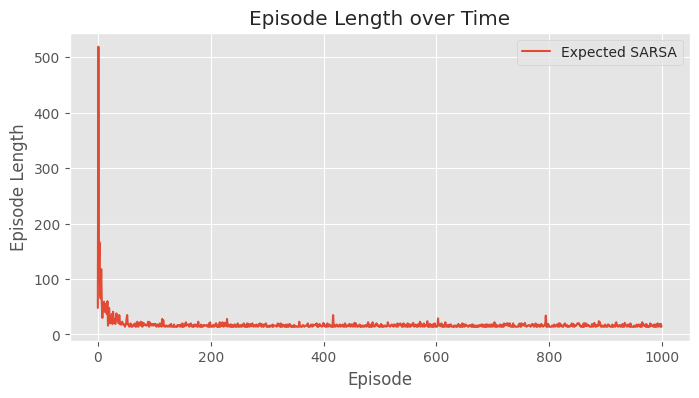

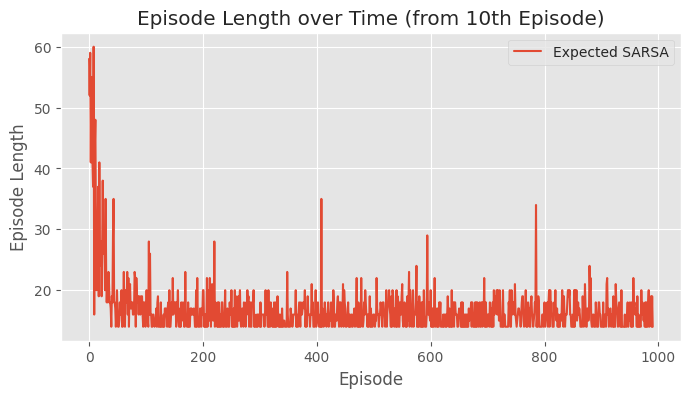

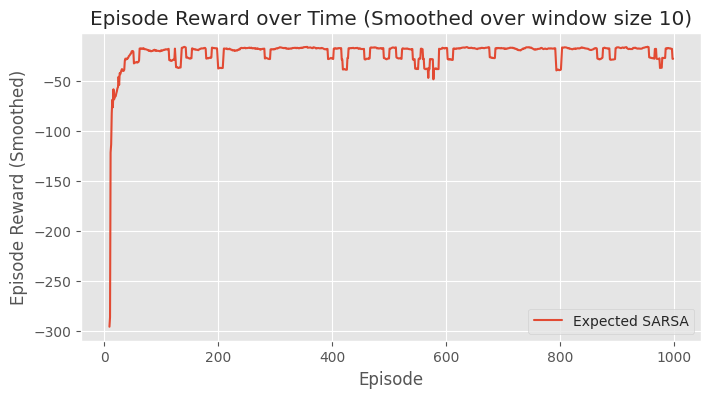

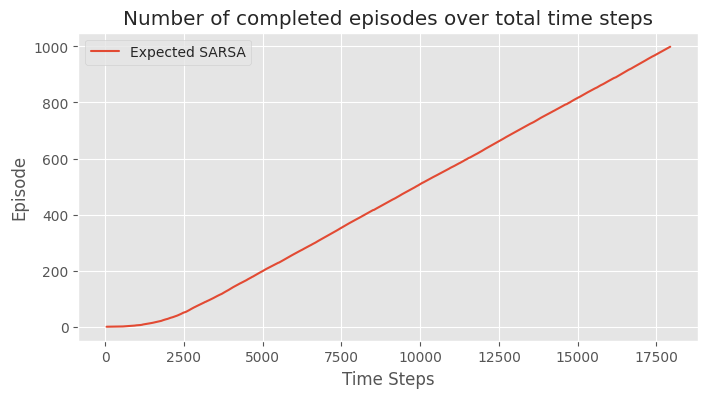

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [38]:
# Plotting episodes

# Parameter
start_plot_from = 10    # Skip the first episodes in graph
smoothing_window = 10

plot_episode_stats(Esarsa_stats['episode_lengths'], Esarsa_stats['episode_rewards'], start_plot_from, smoothing_window, policy='Expected SARSA')

In [39]:
# get greedy policy from Q
policy_Esarsa = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])

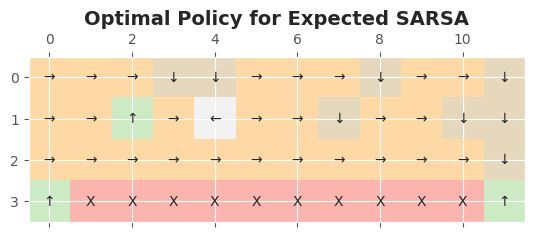

In [40]:
# Plot the optimal policy

# Define the shape of your environment's grid
grid_shape = (4, 12)

# Create opt_policy
opt_policy_Esarsa = np.reshape(policy_Esarsa, (4, 12))

# Create a function to plot the policy
def plot_policy(policy_Esarsa, shape):
    # Define the grid
    #grid = np.argmax(policy, axis=1).reshape(shape)
    grid = policy_Esarsa.reshape(shape)

    # Create a figure and axis
    fig, ax = plt.subplots()
    ax.matshow(grid, cmap=plt.cm.Pastel1)

    # Define the symbols for each action (up, right, down, left)
    actions = {0: '↑', 1: '→', 2: '↓', 3: '←', -1: 'X'}   # 'X' is the cliff

    # Annotate the grid with action symbols
    for i in range(shape[0]):
        for j in range(shape[1]):
            #action_grid = actions[grid[i, j]]
            #ax.text(j, i, action_grid, va='center', ha='center')
            action_symbol = actions.get(grid[i, j], '?')  # '?' for unexpected numbers
            ax.text(j, i, action_symbol, va='center', ha='center')

    plt.title("Optimal Policy for Expected SARSA", fontsize=14, weight='bold')
    plt.show()

# Plot the policy
policy_array = np.array(np.reshape(policy_qlearn, (4, 12)))
plot_policy(policy_array, grid_shape)

In [41]:
optimal_value_function_Esarsa = np.reshape(v, (4, 12))  # 'v' is  optimal value function array

print("Optimal Value Function Expected SARSA:")
for row in optimal_value_function_Esarsa:
    formatted_row = ' '.join(f"{value:6.2f}" for value in row)  # Adjust formatting as needed
    print(formatted_row)
print("")

Optimal Value Function Expected SARSA:
-15.06 -14.04 -12.98 -11.91 -10.89  -9.85  -8.80  -7.72  -6.63  -5.55  -4.47  -3.36
-15.32 -14.14 -12.94 -11.76 -10.56  -9.38  -8.17  -6.98  -5.77  -4.54  -3.36  -2.22
-16.42 -15.32 -14.12 -12.93 -11.73 -10.55  -9.37  -8.16  -6.97  -5.76  -2.22  -1.00
-17.62   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



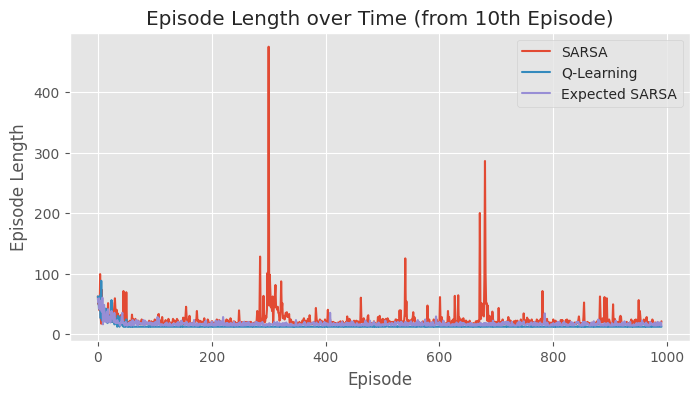

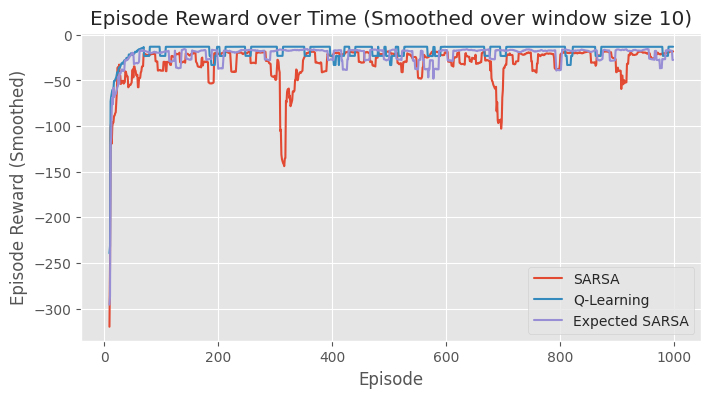

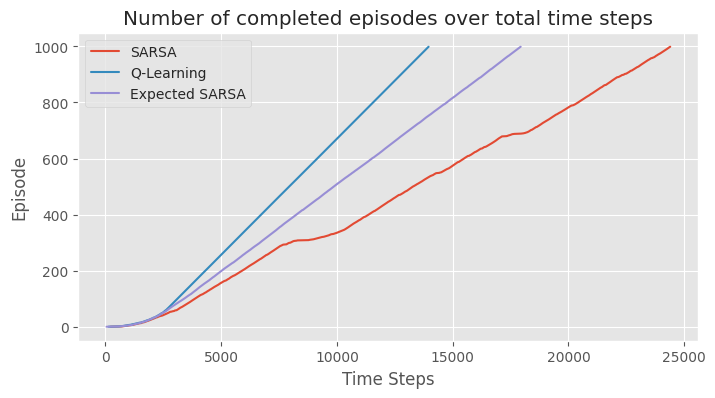

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [42]:
compare_three_episode_stats(sarsa_episode_lengths, q_learning_episode_lengths, Esarsa_episode_lengths,
                            sarsa_episode_rewards, q_learning_episode_rewards, Esarsa_episode_rewards,
                            start_plot_from=10, smoothing_window=10)

# Implement the Double Q-learning algorithm

In [43]:
# Paramters
discount_fact_DQlearning = 1.0
alpha_val_DQlearning = 0.5
epsilon_DQlearning = 0.1
num_episodes_DQlearning = 1000   # number of episodes
display_number_episodes_DQlearning = 0   # Number of episodes to show

def double_q_learning(env, num_episodes, discount_factor=discount_fact_DQlearning, alpha=alpha_val_DQlearning, epsilon=epsilon_DQlearning):
    """
    Double Q-Learning algorithm: Off-policy TD control with reduced overestimation bias.
    It maintains two Q-tables to decouple the action selection and evaluation.

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.

    Returns:
        A tuple (Q1, Q2, stats).
        Q1 and Q2 are the optimal action-value functions, dictionaries mapping state -> action values.
        DQlearning_stats is an object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Key differences in the code, compared to Q-learning
    # Two Q-Tables: Double Q-Learning maintains two Q-tables, while Q-Learning and (Expected) SARSA use only one.
    # Bias Reduction: It specifically addresses and reduces the overestimation bias of action values that can occur in Q-Learning.
    # Action Selection and Evaluation: In Double Q-Learning, action selection, and evaluation are decoupled between the two Q-tables,
    #    while in Q-Learning and SARSA, they are typically coupled within a single Q-table.

    # Initialize two Q-tables
    Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    DQlearning_stats = {'episode_lengths': np.zeros(num_episodes), 'episode_rewards': np.zeros(num_episodes)}

    # For calculating the number of episodes to show
    show_episodes_DQlearning = True
    if display_number_episodes_DQlearning == 0:
        show_episodes_DQlearning = False
    else:
        interval_epi = max(1, num_episodes_DQlearning // display_number_episodes_DQlearning)

    for i_episode in range(num_episodes):
        # Initialize state
        state = env.reset()
        for t in itertools.count():

            # Problem as state is a tuple the first time it is accessed, but an integer the following
            # Extract the state part if it's a tuple with additional info
            if isinstance(state, tuple):
                state = state[0]

            # Epsilon-greedy policy from the combined Q-tables
            combined_q = np.array([Q1[state][a] + Q2[state][a] for a in range(env.action_space.n)])
            if random.random() < epsilon:
                action = random.choice(range(env.action_space.n))
            else:
                action = np.argmax(combined_q)

            # Take a step
            next_state, reward, is_terminal, is_truncated, _ = env.step(action)

            # Problem as state is a tuple the first time it is accessed, but an integer the following
            # Extract the state part if it's a tuple with additional info
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            # Show Agent movements at specific intervals
            if show_episodes_DQlearning:
                if i_episode % interval_epi == 0:  # Check if this episode should be displayed
                    frame = env.render()
                    clear_output(wait=True)   # clear previous image
                    plt.title(f"Episode: {i_episode + 1}/{num_episodes_DQlearning}")  # Display the episode number
                    plt.imshow(frame)
                    #plt.pause(0.1)  # Adjust the pause time as needed for smooth viewing
                    plt.show()

            # Randomly update Q1 or Q2
            if random.random() < 0.5:
                best_next_action = np.argmax(Q1[next_state])
                td_target = reward + discount_factor * Q2[next_state][best_next_action]
                Q1[state][action] += alpha * (td_target - Q1[state][action])
            else:
                best_next_action = np.argmax(Q2[next_state])
                td_target = reward + discount_factor * Q1[next_state][best_next_action]
                Q2[state][action] += alpha * (td_target - Q2[state][action])

            DQlearning_stats['episode_rewards'][i_episode] += reward
            DQlearning_stats['episode_lengths'][i_episode] = t

            if is_terminal:
                break

            # Update state, and timestep
            state = next_state
            t += 1

    return Q1, Q2, DQlearning_stats

In [44]:
%%time
Q1_DQlearning, Q2_DQlearning, DQlearning_stats = double_q_learning(env, num_episodes_DQlearning)

# Collect stats from Double Q-Learning for comparison
DQlearning_episode_lengths = DQlearning_stats['episode_lengths']
DQlearning_episode_rewards = DQlearning_stats['episode_rewards']

CPU times: total: 172 ms
Wall time: 348 ms


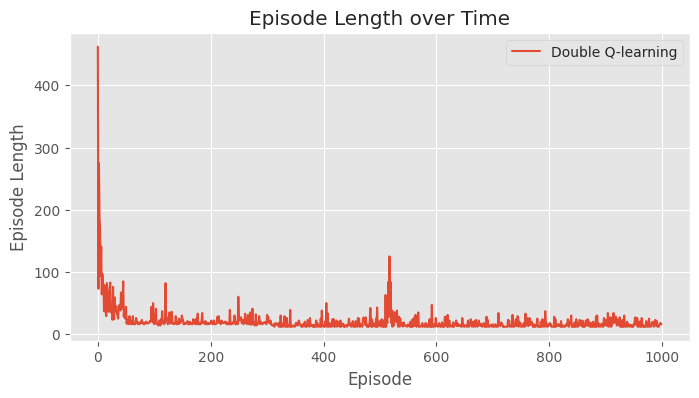

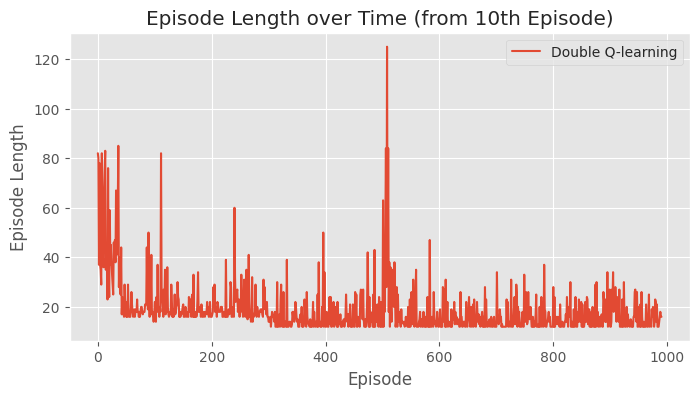

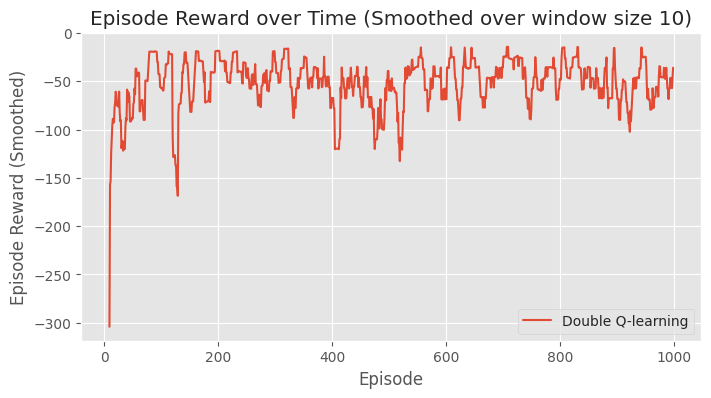

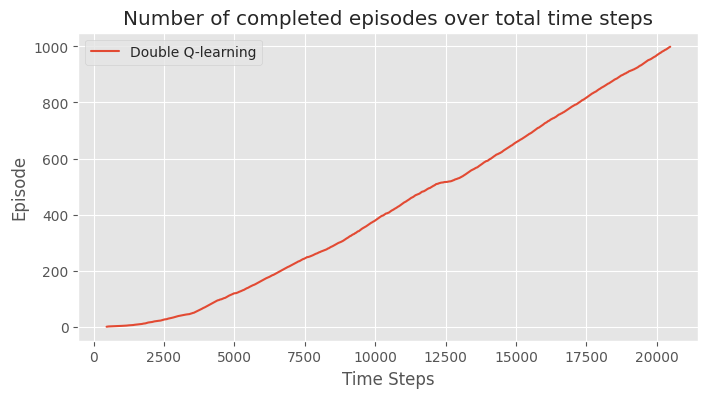

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [45]:
# Plotting episodes

# Parameter
start_plot_from = 10    # Skip the first episodes in graph
smoothing_window = 10

plot_episode_stats(DQlearning_stats['episode_lengths'], DQlearning_stats['episode_rewards'],
                   start_plot_from, smoothing_window, policy='Double Q-learning')

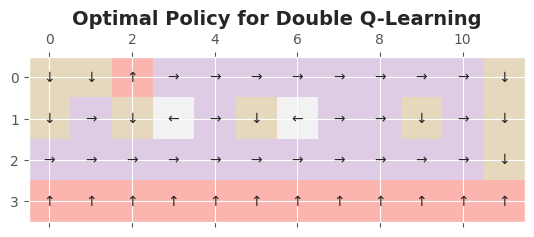

In [46]:
# Calculate the average Q-table from Q1 and Q2
average_Q = defaultdict(lambda: np.zeros(env.action_space.n))
for state in Q1_DQlearning:
    average_Q[state] = (Q1_DQlearning[state] + Q2_DQlearning[state]) / 2

# Determine the optimal policy from the average Q-table
opt_policy_dq = np.array([np.argmax(average_Q[state]) for state in range(env.nS)]).reshape(grid_shape)

# Create a function to plot the policy for Double Q-Learning
def plot_dq_policy(policy_dq, shape):
    grid = policy_dq.reshape(shape)

    fig, ax = plt.subplots()
    ax.matshow(grid, cmap=plt.cm.Pastel1)

    actions = {0: '↑', 1: '→', 2: '↓', 3: '←', -1: 'X'}  # Define the symbols for each action

    for i in range(shape[0]):
        for j in range(shape[1]):
            action_symbol = actions.get(grid[i, j], '?')
            ax.text(j, i, action_symbol, va='center', ha='center')

    plt.title("Optimal Policy for Double Q-Learning", fontsize=14, weight='bold')
    plt.show()

# Plot the optimal policy for Double Q-learning
plot_dq_policy(opt_policy_dq, grid_shape)

In [47]:
# Calculate the average Q-table from Q1 and Q2
average_Q = defaultdict(lambda: np.zeros(env.action_space.n))
for state in range(env.nS):
    average_Q[state] = (Q1_DQlearning[state] + Q2_DQlearning[state]) / 2

# Determine the optimal value function
optimal_value_function_DQ = np.array([np.max(average_Q[state]) for state in range(env.nS)]).reshape(grid_shape)

# Print the optimal value function
print("Optimal Value Function for Double Q-Learning:")
for row in optimal_value_function_DQ:
    formatted_row = ' '.join(f"{value:6.2f}" for value in row)  # Adjust formatting as needed
    print(formatted_row)
print("")


Optimal Value Function for Double Q-Learning:
-111.90 -83.74 -99.58 -94.20 -85.45 -78.43 -52.46 -34.40 -32.01 -18.99  -4.00  -3.00
-14.49 -13.34 -11.00 -12.50 -10.00  -8.00  -9.16 -36.45 -33.39 -18.14  -3.00  -2.00
-12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00  -1.00
-13.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



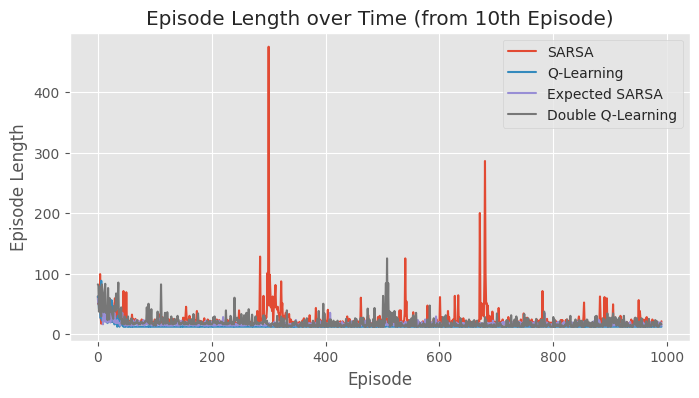

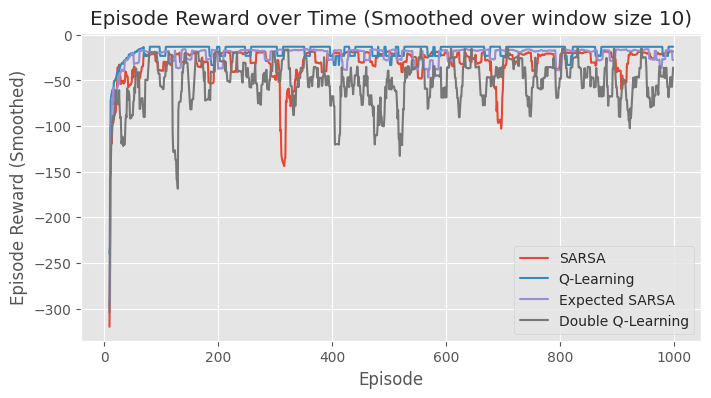

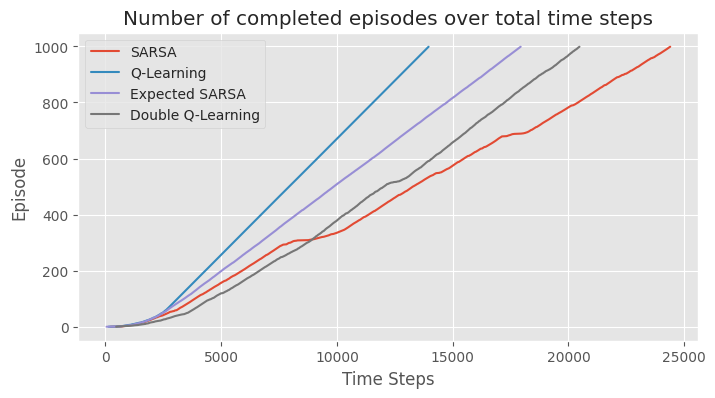

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [48]:
# Compare Episode Lengths and Rewards for all four algorithms
compare_episode_stats_all(sarsa_episode_lengths, q_learning_episode_lengths, Esarsa_episode_lengths, DQlearning_episode_lengths,
                          sarsa_episode_rewards, q_learning_episode_rewards, Esarsa_episode_rewards, DQlearning_episode_rewards,
                          start_plot_from=10, smoothing_window=10)

Double Q-learning seems to perform worse than Q-learning. However, with two Q-tables it might take a bit longer to converge. Let's see if this is the case.

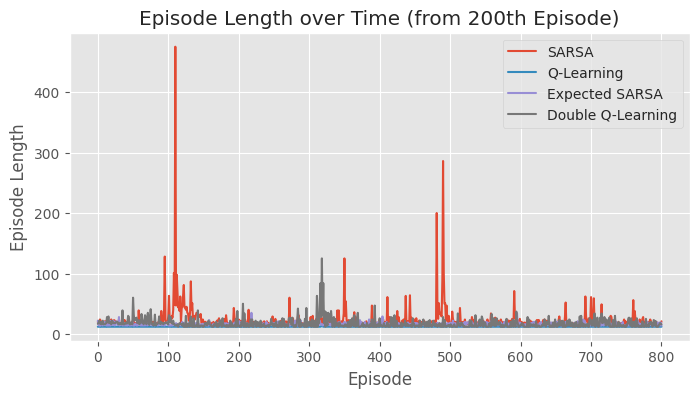

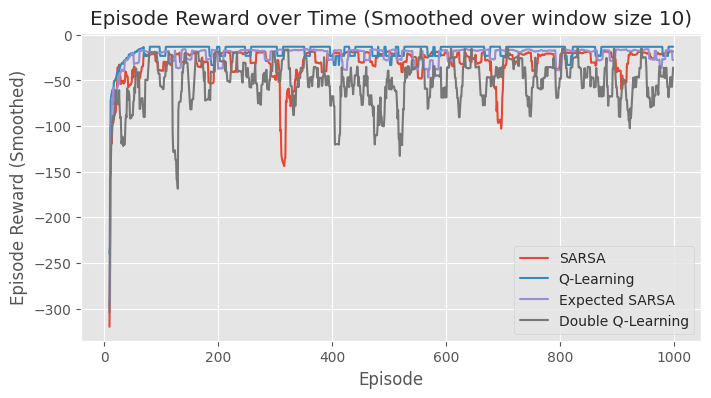

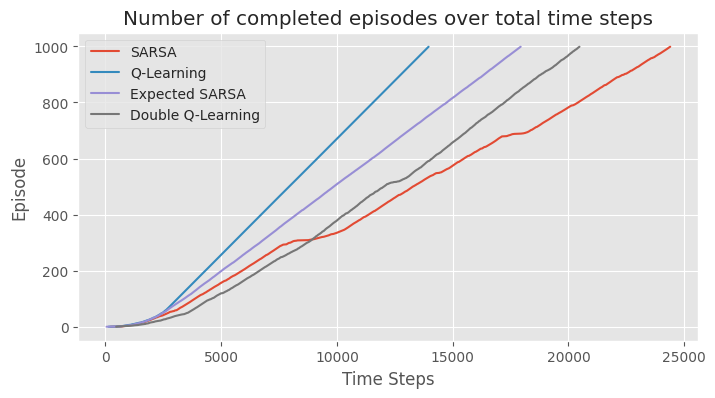

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [49]:
# Compare Episode Lengths and Rewards for all four algorithms
compare_episode_stats_all(sarsa_episode_lengths, q_learning_episode_lengths, Esarsa_episode_lengths, DQlearning_episode_lengths,
                          sarsa_episode_rewards, q_learning_episode_rewards, Esarsa_episode_rewards, DQlearning_episode_rewards,
                          start_plot_from=200, smoothing_window=10)

In [50]:
#With the chosen hyperparameter setting, Q-learning is still the most robust and fastest.

#  How do the learned policis and (state-action) value functions differ?

### SARSA (State-Action-Reward-State-Action):
1. **Policy:** SARSA is an on-policy algorithm, meaning it learns the value of the policy it follows, including the exploration steps.
2. **Policy Behavior:** SARSA tends to learn a more conservative policy. Since it takes the next action's potential epsilon-greedy choice into account while learning, it's more likely to avoid actions that could lead to a significant negative outcome under an epsilon-greedy policy.
3. **Value Function:**
 The value function learned reflects the expected return for following the epsilon-greedy policy all the time, not just the best-known policy.

### Q-Learning:
1. **Policy:** Q-learning is an off-policy algorithm. It learns the value of the optimal policy, regardless of the agent's actions, making it more aggressive in its policy improvement.
2. **Policy Behavior:** Q-learning tends to learn a more optimal policy faster than SARSA in many cases because it always considers the best possible next action (greedy) rather than the actual next action as SARSA does.
3. **Value Function:** The value function learned represents the maximum expected return achievable from each state, assuming a transition to the best possible next state. This can sometimes lead to an overestimation of state-action values due to the max operation in its update rule.

### Expected SARSA:
1. **Policy:** Expected SARSA is an on-policy algorithm like SARSA but takes into account the expected value of the next state, considering all possible actions. This makes it more stable and often more effective than standard SARSA.
2. **Policy Behavior:** Expected SARSA's policy usually falls between SARSA's conservativeness and Q-learning's aggressiveness. It considers the expected outcome of the current policy's actions rather than just the next action.
3. **Value Function:** The value function in Expected SARSA is an average of the SARSA and Q-learning value functions, considering the probabilities of each action. It generally provides a better estimate than SARSA in stochastic environments.

### Double Q-Learning:
1. **Policy:** Double Q-learning is an off-policy algorithm like Q-learning but addresses Q-learning's tendency to overestimate action values due to the noise in the max operation.
2. **Policy Behavior:** Double Q-learning tends to learn more accurate policies in environments where the overestimation of Q-values is a significant issue. It uses two Q-tables to decouple the action selection and action evaluation, reducing positive bias in the value estimation.
3. **Value Function:** The value function in Double Q-learning is expected to be more accurate and less prone to overestimation than standard Q-learning. Each of the two Q-tables provides an independent estimate, which helps in identifying and reducing overestimations.

### Comparing the Algorithms:
1. **Exploration vs. Exploitation:** All these algorithms use an epsilon-greedy strategy for exploration, but their learned policies reflect their unique update mechanisms and exploration-exploitation balances.
2. **Convergence Rate:** Q-learning and Expected SARSA often converge faster to the optimal policy than SARSA, especially in deterministic environments. Double Q-learning can be more reliable in terms of convergence to the true values due to reduced overestimation.
3. **Performance in Stochastic Environments:** In environments where certain actions can have significantly varied results, SARSA and Expected SARSA might perform better as they account for the policy's stochastic nature.
4. **Sensitivity to Parameters:** The performance of all algorithms is sensitive to their hyperparameters (alpha, gamma, epsilon). However, due to the different ways they update their Q-values, some might be more robust to suboptimal parameter choices than others.stness to parameter selection.


#  Reproduce the best path taken for each policy

In [51]:
def find_best_path(policy_or_q_table, start_state, goal_state, grid_shape, model):
    """
    Find the best path from the start state to the goal state given a policy or Q-table.

    Args:
        policy_or_q_table: The policy or Q-table to use for determining the best action.
        start_state: The starting state as a tuple (row, column).
        goal_state: The goal state as a tuple (row, column).
        grid_shape: The shape of the grid as a tuple (rows, columns).

    Returns:
        A list of states representing the best path from the start to the goal.
    """

    current_state = start_state
    best_path = [current_state]

    # Convert 2D state to 1D index if policy_or_q_table is a policy array
    is_policy = isinstance(policy_or_q_table, np.ndarray) and policy_or_q_table.ndim == 1

    while current_state != goal_state:
        if is_policy:
            # Convert the 2D state to a 1D index for policy arrays
            state_index = np.ravel_multi_index(current_state, grid_shape)
            best_action = policy_or_q_table[state_index]
        else:  # Assuming a Q-table
            best_action = np.argmax(policy_or_q_table[current_state])

        #Debug
        #print(f"Current State: {current_state}, Action: {best_action}, Next State: {next_state}")

        next_state = move_agent(current_state, best_action, grid_shape)
        best_path.append(next_state)
        current_state = next_state

        if len(best_path) > grid_shape[0] * grid_shape[1]:
            print("Warning: Stuck in a loop. Check the policy or Q-table for", model)
            break

    return best_path


def move_agent(current_state, action, grid_shape):
    """
    Determines the next state given the current state and an action.

    Args:
        current_state: The current state as a tuple (row, column).
        action: The action to take (encoded as an integer).
        grid_shape: The shape of the grid as a tuple (rows, columns).

    Returns:
        The next state as a tuple (row, column).
    """
    # Define action effects (assuming 0: up, 1: right, 2: down, 3: left)
    action_effects = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}

    # Calculate the next state
    effect = action_effects[action]
    next_state = (min(max(current_state[0] + effect[0], 0), grid_shape[0] - 1),
                  min(max(current_state[1] + effect[1], 0), grid_shape[1] - 1))

    return next_state

In [52]:
# Run to find the best path for each algorithm

start_state = (grid_shape[0]-1, 0)  # The start is the bottom-left corner
goal_state = (grid_shape[0]-1, grid_shape[1]-1)  # Goal is the bottom-right corner

best_path_sarsa = find_best_path(policy_sarsa, start_state, goal_state, grid_shape, 'SARSA')
best_path_q_learning = find_best_path(policy_qlearn, start_state, goal_state, grid_shape, 'Q-learning')
best_path_exp_sarsa = find_best_path(policy_Esarsa, start_state, goal_state, grid_shape, 'Expected-SARSA')
# For Double Q-learning we have a different format on the policy, so need to convert it from 2D to 1D array
opt_policy_dq_flat = np.array(opt_policy_dq).flatten()
best_path_double_q = find_best_path(opt_policy_dq_flat, start_state, goal_state, grid_shape, 'Double-Q-learning')

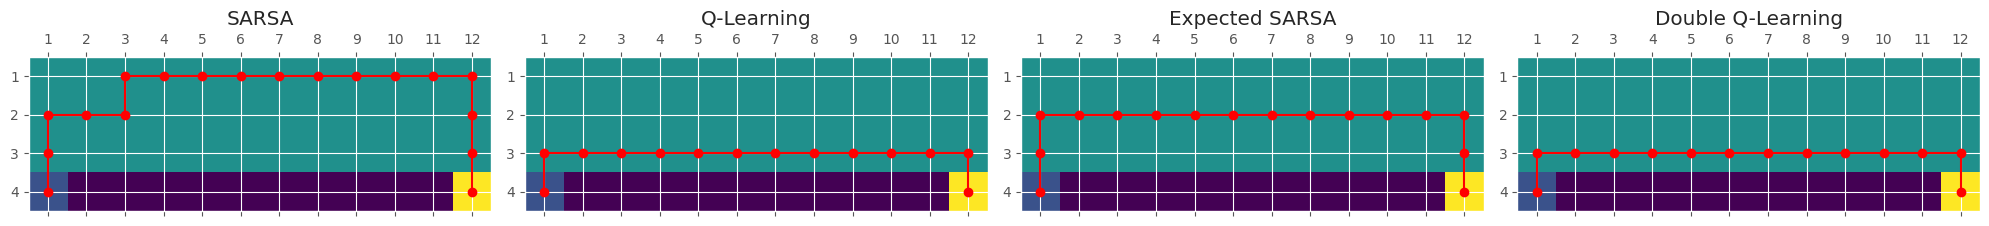

In [53]:
def plot_separate_best_paths(grid_shape, paths, labels, start, goal, cliff_coords):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns of subplots

    for i, (path, label) in enumerate(zip(paths, labels)):
        # Create a grid to represent the environment for each subplot
        grid = np.zeros(grid_shape)

        # Mark the start, goal, and cliff
        grid[start] = -1
        grid[goal] = 2
        for c in cliff_coords:
            grid[c] = -2

        # Set the current subplot
        ax = axs[i]
        ax.matshow(grid, cmap=plt.cm.viridis)

        # Plot the path on the current subplot
        y, x = zip(*path)
        ax.plot(x, y, label=label, marker='o', linestyle='-', color='r')

        # Customize each subplot
        ax.set_xticks(np.arange(grid_shape[1]))
        ax.set_yticks(np.arange(grid_shape[0]))
        ax.set_xticklabels(np.arange(1, grid_shape[1]+1))
        ax.set_yticklabels(np.arange(1, grid_shape[0]+1))
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

# Assuming you have start_state, goal_state, grid_shape defined and paths calculated
grid_shape = (4, 12)  # Update with your environment's shape
cliff_coords = [(grid_shape[0]-1, c) for c in range(1, grid_shape[1]-1)]  # Update with your environment's cliff coordinates

plot_separate_best_paths(grid_shape,
                         [best_path_sarsa, best_path_q_learning, best_path_exp_sarsa, best_path_double_q],
                         ['SARSA', 'Q-Learning', 'Expected SARSA', 'Double Q-Learning'],
                         start_state, goal_state, cliff_coords)


which, to a large extent, resembles the image in the book on page 132, where SARSA takes the "safer" path and Q-learning the optimal but "more risky" one.

# Reduced epsilon

What do the policies look like when the parameter ε is gradually reduced over time (called **epsilon decay**),
do they change?

In [54]:
# Paramters
discount_fact_Qlearn = 1.0
alpha_val_Qlearn = 0.5
epsilon_start_Qlearn = 1.0
epsilon_min_Qlearn = 0
epsilon_decay_Qlearn = 0.99
num_episodes_Qlearn = 1000   # number of episodes
display_number_episodes_Qlearn = 0   # Number of episodes to show

def q_learning_DecEpsilon(env, num_episodes_Qlearn=num_episodes_Qlearn, discount_factor=discount_fact_Qlearn,
               alpha=alpha_val_Qlearn, epsilon_start=epsilon_start_Qlearn, epsilon_min=epsilon_min_Qlearn, epsilon_decay=epsilon_decay_Qlearn):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy while following an epsilon-greedy policy

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.

    Returns:
        A tuple (Q, Qlearn_stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        Qlearn_stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    Qlearn_stats = {'episode_lengths': np.zeros(num_episodes_Qlearn), 'episode_rewards': np.zeros(num_episodes_Qlearn)}

    # Initialize epsilon
    epsilon_Qlearn = epsilon_start_Qlearn

    # For calculating the number of episodes to show
    show_episodes_Qlearn = True
    if display_number_episodes_Qlearn == 0:
        show_episodes_Qlearn = False
    else:
        interval_epi = max(1, num_episodes_Qlearn // display_number_episodes_Qlearn)

    # The policy we're following
    policy_qlearn_DecEpsilon = make_epsilon_greedy_policy(Q, epsilon_Qlearn, env.action_space.n)

    for i_episode in range(num_episodes_Qlearn):

        # Reset the environment
        state = env.reset()
        t = 0   # Initialize timestep t

        # Decay epsilon at each episode
        epsilon_Qlearn = max(epsilon_min_Qlearn, epsilon_Qlearn * epsilon_decay_Qlearn)

        while True:
            # Problem as state is a tuple the first time it is accessed, but an integer the following
            # Extract the state part if it's a tuple with additional info
            if isinstance(state, tuple):
                state = state[0]

            # Choose action based on epsilon-greedy policy
            if np.random.rand() < epsilon_Qlearn:
                action = np.random.choice(env.action_space.n)
            else:
                action = np.argmax(Q[state])

            # Take action and observe reward and next state
            next_state, reward, is_terminal, is_truncated, _ = env.step(action)

            # Problem as state is a tuple the first time it is accessed, but an integer the following
            # Extract the state part if it's a tuple with additional info
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            # Show Agent movements at specific intervals
            if show_episodes_Qlearn:
                if i_episode % interval_epi == 0:  # Check if this episode should be displayed
                    frame = env.render()
                    clear_output(wait=True)   # clear previous image
                    plt.title(f"Episode: {i_episode + 1}/{num_episodes_Qlearn}")  # Display the episode number
                    plt.imshow(frame)
                    #plt.pause(0.1)  # Adjust the pause time as needed for smooth viewing
                    plt.show()

            # Update Q-Table
            best_next_action = np.argmax(Q[next_state])

            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

        #probs = policy_qlearn(state)

            Qlearn_stats['episode_rewards'][i_episode] += reward
            Qlearn_stats['episode_lengths'][i_episode] = t

            if is_terminal:
                break

            state = next_state
            #action = best_next_action
            t += 1   # Increment timestep

    return Q, Qlearn_stats

In [55]:
%%time
Q_q_learning_DecEpsilon, Qlearn_stats_DecEpsilon = q_learning_DecEpsilon(env)

# Collect stats from Q-Learning for comparison
q_learning_episode_lengths_DecEpsilon = Qlearn_stats_DecEpsilon['episode_lengths']
q_learning_episode_rewards_DecEpsilon = Qlearn_stats_DecEpsilon['episode_rewards']

CPU times: total: 500 ms
Wall time: 921 ms


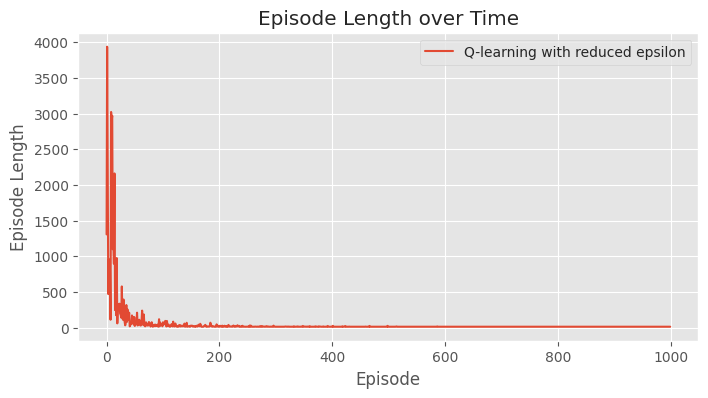

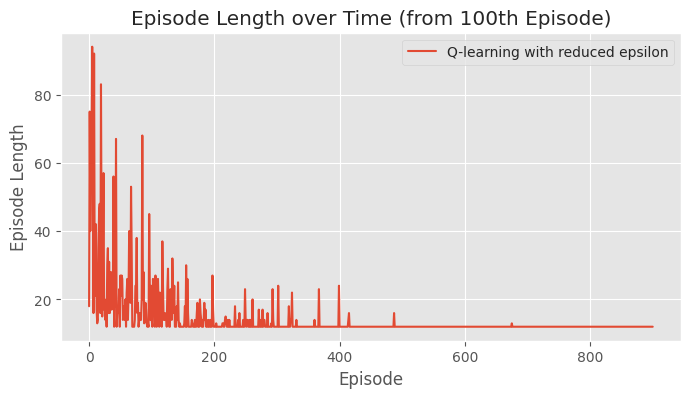

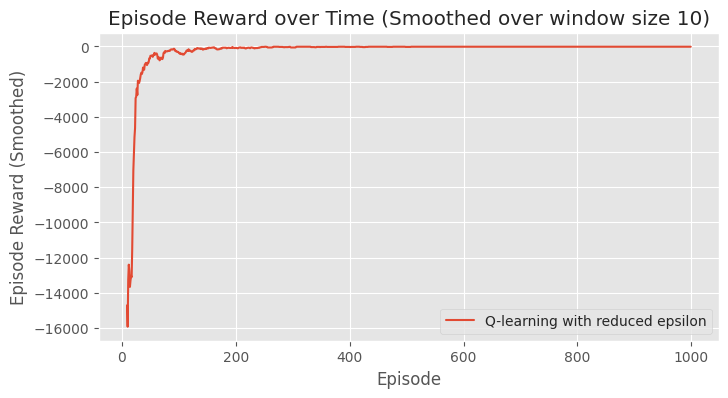

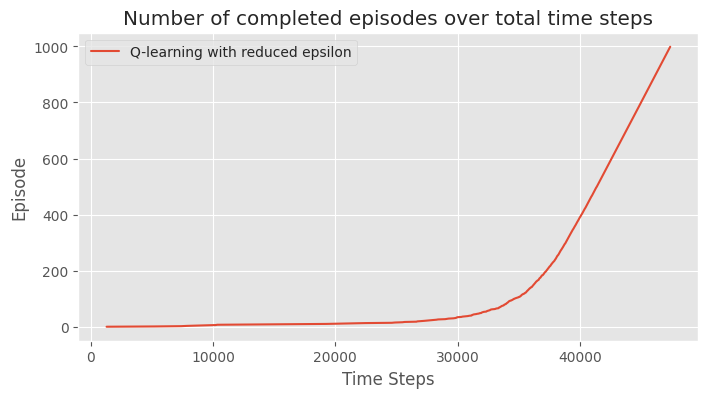

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [56]:
# Plotting episodes

# Parameter
start_plot_from = 100    # Skip the first episodes in graph
smoothing_window = 10

plot_episode_stats(Qlearn_stats_DecEpsilon['episode_lengths'], Qlearn_stats_DecEpsilon['episode_rewards'],
                   start_plot_from, smoothing_window, policy='Q-learning with reduced epsilon')

In [57]:
# get greedy policy from Q
policy_qlearn_DecEpsilon = np.array([np.argmax(Q_q_learning_DecEpsilon[key]) if key in Q_q_learning_DecEpsilon else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v_q_learning_DecEpsilon = ([np.max(Q_q_learning_DecEpsilon[key]) if key in Q_q_learning_DecEpsilon else 0 for key in np.arange(48)])

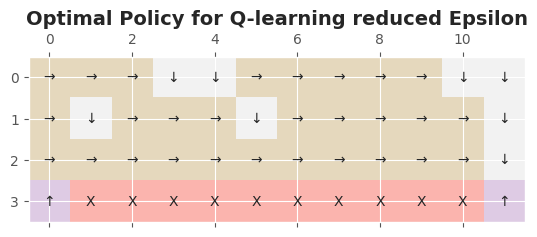

In [58]:
# Plot the optimal policy

# Define the shape of your environment's grid
grid_shape = (4, 12)

# Create opt_policy
opt_policy_qlearn_DecEpsilon = np.reshape(policy_qlearn_DecEpsilon, (4, 12))

# Create a function to plot the policy
def plot_policy(policy_qlearn, shape):
    # Define the grid
    #grid = np.argmax(policy, axis=1).reshape(shape)
    grid = policy_qlearn.reshape(shape)

    # Create a figure and axis
    fig, ax = plt.subplots()
    ax.matshow(grid, cmap=plt.cm.Pastel1)

    # Define the symbols for each action (up, right, down, left)
    actions = {0: '↑', 1: '→', 2: '↓', 3: '←', -1: 'X'}   # 'X' is the cliff

    # Annotate the grid with action symbols
    for i in range(shape[0]):
        for j in range(shape[1]):
            #action_grid = actions[grid[i, j]]
            #ax.text(j, i, action_grid, va='center', ha='center')
            action_symbol = actions.get(grid[i, j], '?')  # '?' for unexpected numbers
            ax.text(j, i, action_symbol, va='center', ha='center')

    plt.title("Optimal Policy for Q-learning reduced Epsilon", fontsize=14, weight='bold')
    plt.show()

# Plot the policy
policy_array = np.array(np.reshape(policy_qlearn_DecEpsilon, (4, 12)))
plot_policy(policy_array, grid_shape)

In [59]:
optimal_value_function_Qlearn_DecEpsilon = np.reshape(v_q_learning_DecEpsilon, (4, 12))  # 'v' is optimal value function array

print("Optimal Value Function Q-learn with decaying Epsilon:")
for row in optimal_value_function_Qlearn_DecEpsilon:
    formatted_row = ' '.join(f"{value:6.2f}" for value in row)  # Adjust formatting as needed
    print(formatted_row)
print("")

Optimal Value Function Q-learn with decaying Epsilon:
-14.00 -13.00 -12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00
-13.00 -12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00
-12.00 -11.00 -10.00  -9.00  -8.00  -7.00  -6.00  -5.00  -4.00  -3.00  -2.00  -1.00
-13.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



## Let's compare the two Q-learning, with fixed and decayed epsilon, first from start

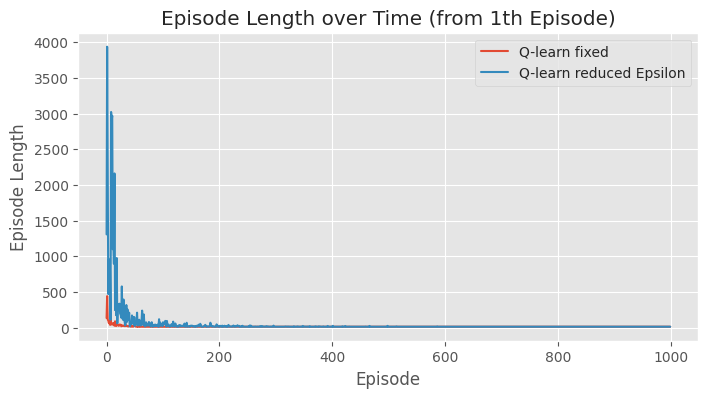

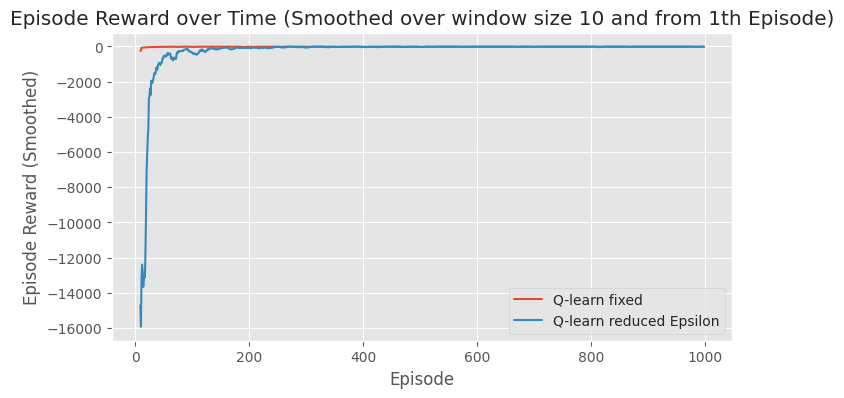

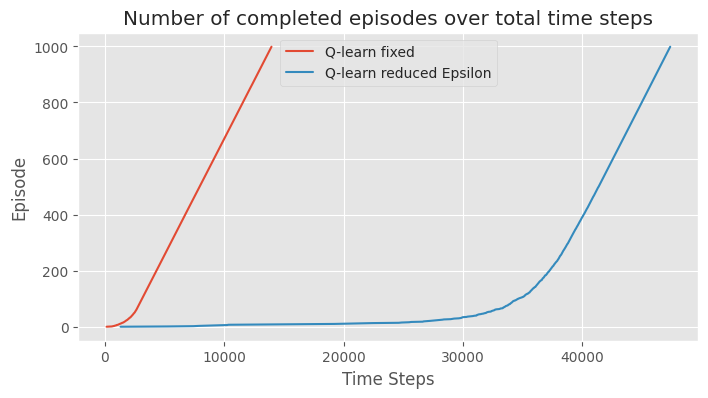

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [60]:
# Compare Episode Lengths
compare_two_episode_stats(q_learning_episode_lengths, q_learning_episode_lengths_DecEpsilon,
                      q_learning_episode_rewards, q_learning_episode_rewards_DecEpsilon,
                      start_plot_from=1, smoothing_window=10, policy1='Q-learn fixed', policy2='Q-learn reduced Epsilon')

In [61]:
## and then from 100th episode

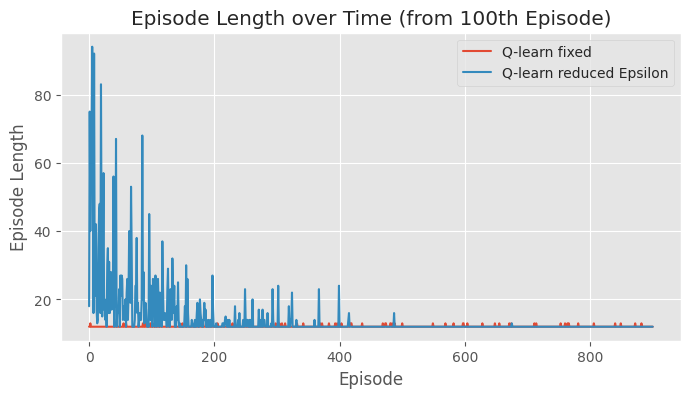

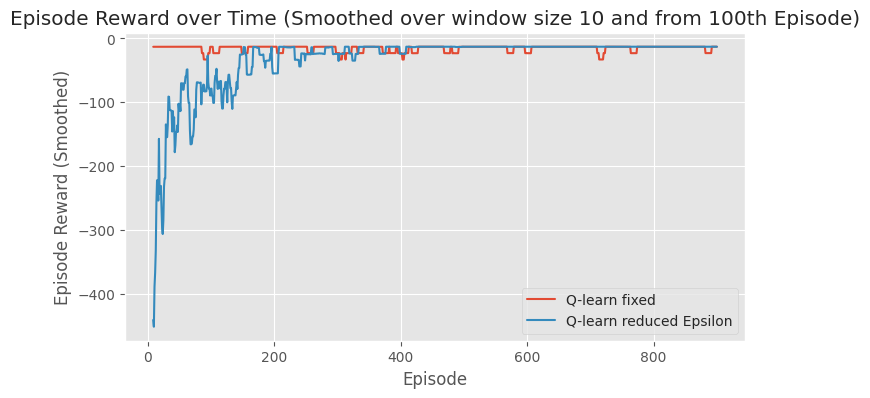

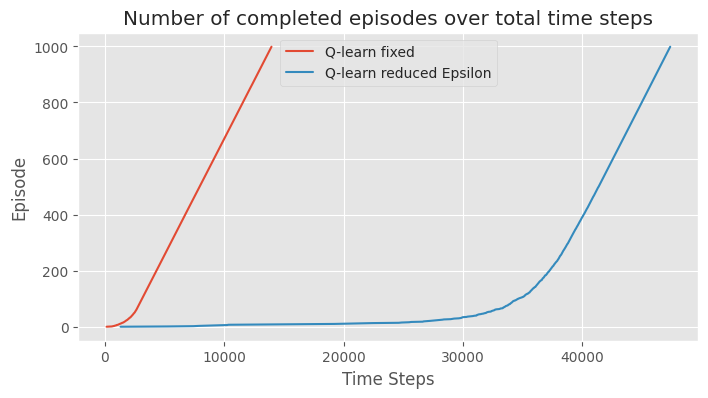

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [62]:
# Compare Episode Lengths
compare_two_episode_stats(q_learning_episode_lengths, q_learning_episode_lengths_DecEpsilon,
                      q_learning_episode_rewards, q_learning_episode_rewards_DecEpsilon,
                      start_plot_from=100, smoothing_window=10, policy1='Q-learn fixed', policy2='Q-learn reduced Epsilon')

## RESULT

1. Very much higher (negative) rewards at the start, when epsilon = 1.0, ie only eploration, which is expected
2. Takes longer time to go through all episodes
3. The final reault is mor estable with the decaying epsiolon algorithm
   
As we have problems with SARSA suddenly having many more steps in later episodes, let's try the reduced epsilon with SARSA as well.

In [63]:
# Paramters
discount_fact_SARSA = 1.0
alpha_val_SARSA = 0.5
epsilon_start_SARSA = 1.0
epsilon_min_SARSA = 0
epsilon_decay_SARSA = 0.99
num_episodes_SARSA= 1000   # number of episodes
display_number_episodes_SARSA = 0   # Number of episodes to show

def SARSA_DecEpsilon(env, num_episodes_SARSA=num_episodes_SARSA, discount_factor=discount_fact_SARSA,
               alpha=alpha_val_SARSA, epsilon_start=epsilon_start_SARSA, epsilon_min=epsilon_min_SARSA, epsilon_decay=epsilon_decay_SARSA):

    """
    SARSA algorithm with epsilon decay.
    SARSA = On-policy TD control.
    """

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    SARSA_stats = {'episode_lengths': np.zeros(num_episodes_SARSA), 'episode_rewards': np.zeros(num_episodes_SARSA)}

    # Initialize epsilon
    epsilon_SARSA = epsilon_start

    # For calculating the number of episodes to show
    show_episodes_SARSA = True
    if display_number_episodes_SARSA == 0:
        show_episodes_SARSA = False
    else:
        interval_epi = max(1, num_episodes_SARSA // display_number_episodes_SARSA)

    for i_episode in range(num_episodes_SARSA):

        # Reset the environment
        state = env.reset()
        epsilon_SARSA = max(epsilon_min, epsilon_SARSA * epsilon_decay)  # Decay the epsilon value
        policy_SARSA_DecEpsilon = make_epsilon_greedy_policy(Q, epsilon_SARSA, env.action_space.n)  # Update policy with new epsilon

        # Problem as state is a tuple the first time it is accessed, but an integer the following
        # Extract the state part if it's a tuple with additional info
        if isinstance(state, tuple):
            state = state[0]

        probs = policy_SARSA_DecEpsilon(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        #action = np.random.choice(np.arange(len(Q[state])), p=policy_sarsa(state))
        t = 0   # Initialize timestep t

        for t in itertools.count():
            next_state, reward, is_terminal, is_truncated, _ = env.step(action)

            next_probs = policy_SARSA_DecEpsilon(next_state)
            #next_action = np.random.choice(np.arange(len(Q[next_state])), p=next_probs)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)

            # Problem as state is a tuple the first time it is accessed, but an integer the following
            # Extract the state part if it's a tuple with additional info
            if isinstance(next_state, tuple):
                next_state = next_state[0]

            # Show Agent movements at specific intervals
            if show_episodes_SARSA:
                if i_episode % interval_epi == 0:  # Check if this episode should be displayed
                    frame = env.render()
                    clear_output(wait=True)   # clear previous image
                    plt.title(f"Episode: {i_episode + 1}/{num_episodes_Qlearn}")  # Display the episode number
                    plt.imshow(frame)
                    #plt.pause(0.1)  # Adjust the pause time as needed for smooth viewing
                    plt.show()

            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            SARSA_stats['episode_rewards'][i_episode] += reward
            SARSA_stats['episode_lengths'][i_episode] = t


            if is_terminal:
                break

            state = next_state
            action = next_action
            t += 1   # Increment timestep

    return Q, SARSA_stats

In [64]:
%%time
Q_SARSA_DecEpsilon, SARSA_stats_DecEpsilon = SARSA_DecEpsilon(env)

# Collect stats from Q-Learning for comparison
SARSA_episode_lengths_DecEpsilon = SARSA_stats_DecEpsilon['episode_lengths']
SARSA_episode_rewards_DecEpsilon = SARSA_stats_DecEpsilon['episode_rewards']

CPU times: total: 828 ms
Wall time: 1.81 s


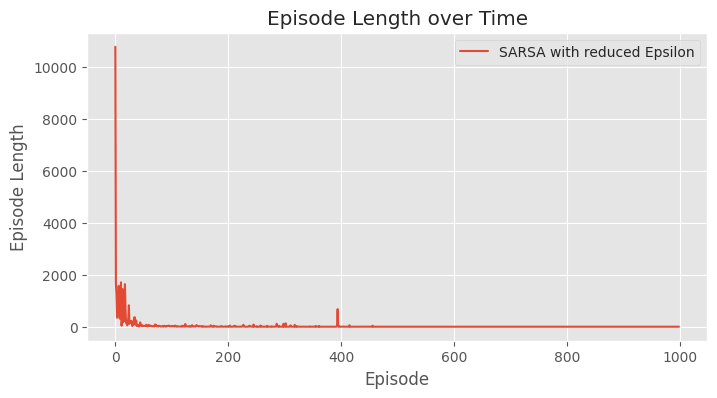

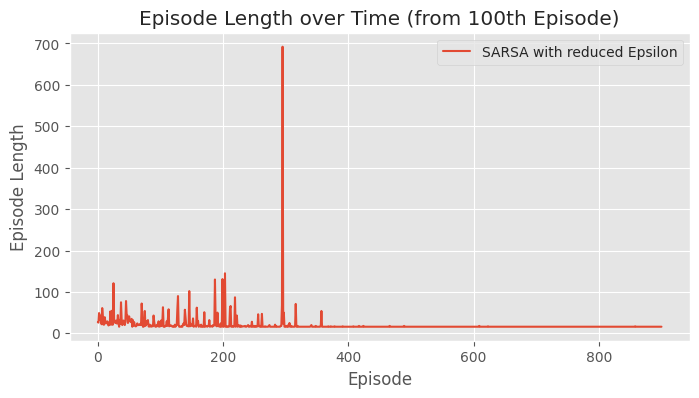

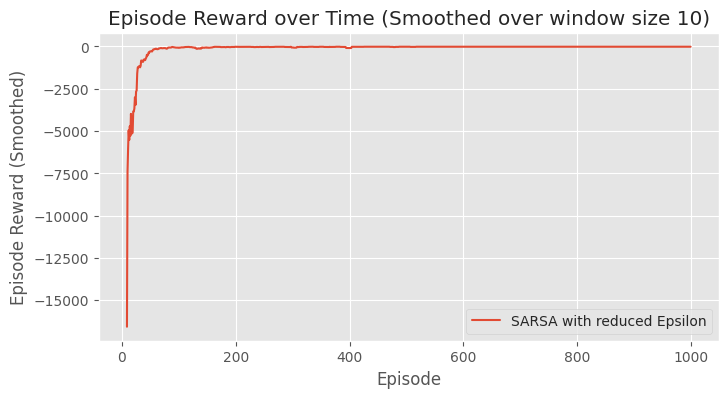

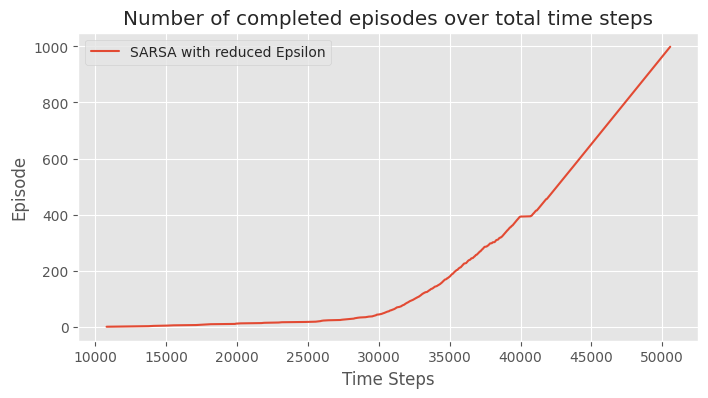

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [65]:
# Plotting episodes

# Parameter
start_plot_from = 100    # Skip the first episodes in graph

plot_episode_stats(SARSA_stats_DecEpsilon['episode_lengths'], SARSA_stats_DecEpsilon['episode_rewards'],
                   start_plot_from, smoothing_window, policy='SARSA with reduced Epsilon')

## Let's compare the two SARSA, with fixed and reduced epsilon, first from start

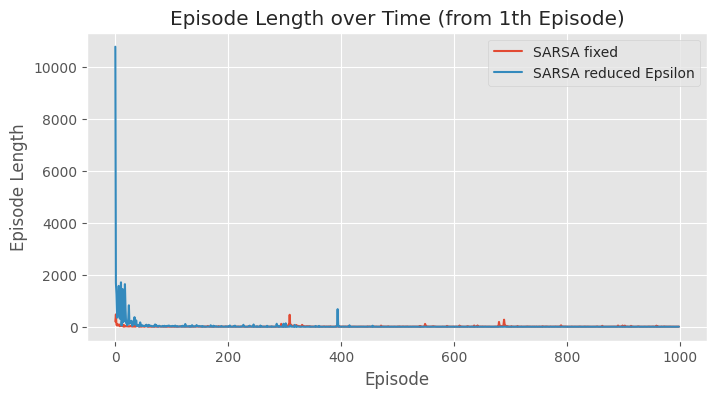

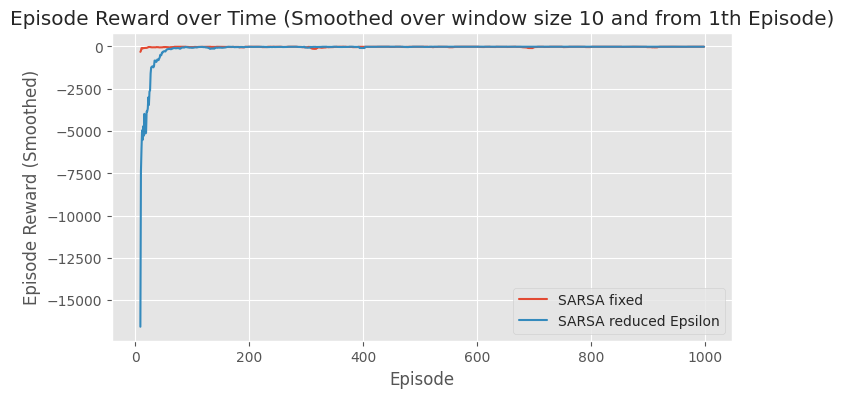

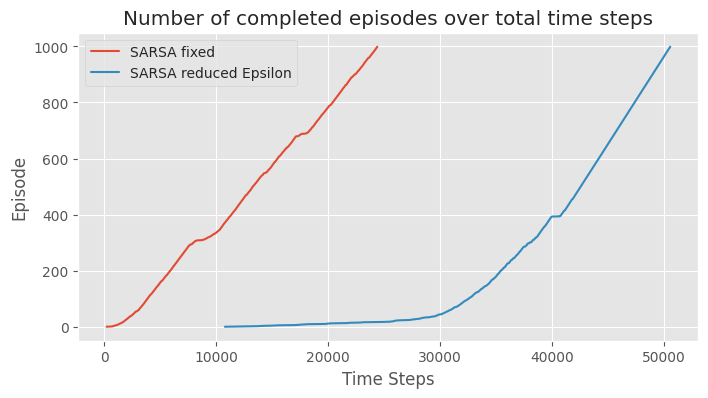

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [66]:
# Compare Episode Lengths
compare_two_episode_stats(sarsa_episode_lengths, SARSA_episode_lengths_DecEpsilon,
                      sarsa_episode_rewards, SARSA_episode_rewards_DecEpsilon,
                      start_plot_from=1, smoothing_window=10, policy1='SARSA fixed', policy2='SARSA reduced Epsilon')

## and then from 100th episode

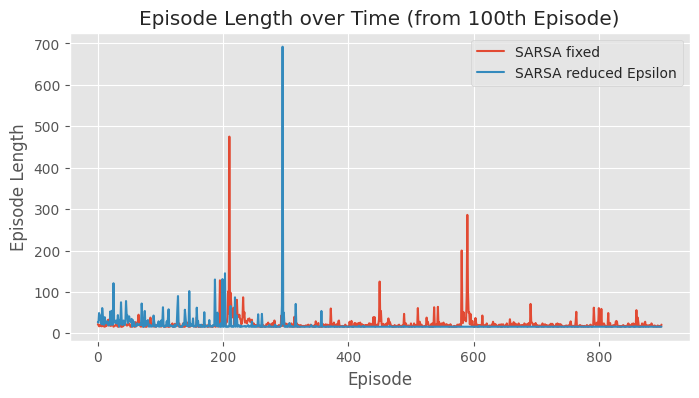

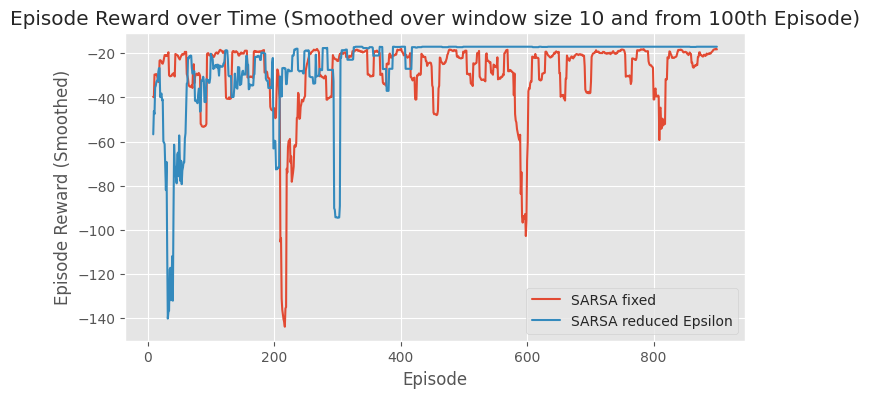

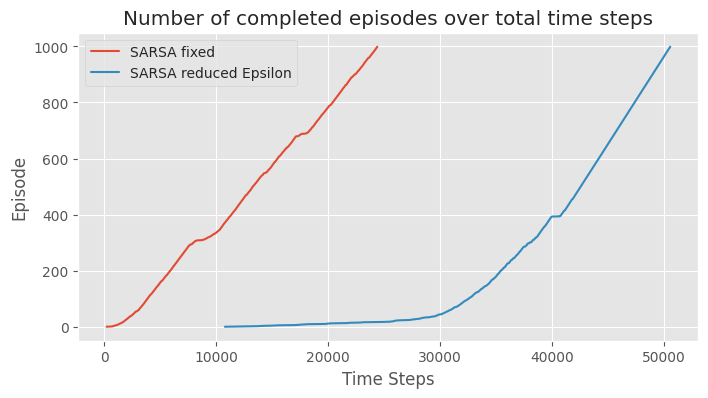

(<Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>,
 <Figure size 800x400 with 1 Axes>)

In [67]:
# Compare Episode Lengths
compare_two_episode_stats(sarsa_episode_lengths, SARSA_episode_lengths_DecEpsilon,
                      sarsa_episode_rewards, SARSA_episode_rewards_DecEpsilon,
                      start_plot_from=100, smoothing_window=10, policy1='SARSA fixed', policy2='SARSA reduced Epsilon')

RESULT:

1. As for Q-learning, very much higher (negative) rewards at the start, when epsilon = 1.0, ie only exploration, which is expected
2. Takes longer time to go through all episodes
3. The final reault is really estable with the decaying epsilon algorithm, taking SARSA from unstable to a stable algorithm

In [68]:
# get greedy policy from Q
policy_SARSA_DecEpsilon = np.array([np.argmax(Q_SARSA_DecEpsilon[key]) if key in Q_SARSA_DecEpsilon else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v_SARSA_DecEpsilon = ([np.max(Q_SARSA_DecEpsilon[key]) if key in Q_SARSA_DecEpsilon else 0 for key in np.arange(48)])

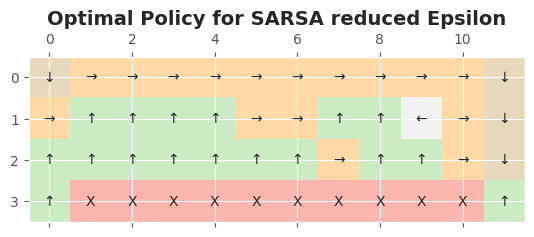

In [69]:
# Plot the optimal policy

# Define the shape of your environment's grid
grid_shape = (4, 12)

# Create opt_policy
opt_policy_qlearn_DecEpsilon = np.reshape(policy_qlearn_DecEpsilon, (4, 12))

# Create a function to plot the policy
def plot_policy(policy_SARSA, shape):
    # Define the grid
    #grid = np.argmax(policy, axis=1).reshape(shape)
    grid = policy_SARSA.reshape(shape)

    # Create a figure and axis
    fig, ax = plt.subplots()
    ax.matshow(grid, cmap=plt.cm.Pastel1)

    # Define the symbols for each action (up, right, down, left)
    actions = {0: '↑', 1: '→', 2: '↓', 3: '←', -1: 'X'}   # 'X' is the cliff

    # Annotate the grid with action symbols
    for i in range(shape[0]):
        for j in range(shape[1]):
            #action_grid = actions[grid[i, j]]
            #ax.text(j, i, action_grid, va='center', ha='center')
            action_symbol = actions.get(grid[i, j], '?')  # '?' for unexpected numbers
            ax.text(j, i, action_symbol, va='center', ha='center')

    plt.title("Optimal Policy for SARSA reduced Epsilon", fontsize=14, weight='bold')
    plt.show()

# Plot the policy
policy_array = np.array(np.reshape(policy_SARSA_DecEpsilon, (4, 12)))
plot_policy(policy_array, grid_shape)

In [70]:
optimal_value_function_SARSA_DecEpsilon = np.reshape(v_SARSA_DecEpsilon, (4, 12))  # 'v' is optimal value function array

print("Optimal Value Function SARSA with decaying Epsilon:")
for row in optimal_value_function_SARSA_DecEpsilon:
    formatted_row = ' '.join(f"{value:7.2f}" for value in row)  # Adjust formatting as needed
    print(formatted_row)
print("")

Optimal Value Function SARSA with decaying Epsilon:
 -88.43  -13.00  -12.00  -11.00  -10.00   -9.00   -8.00   -7.00   -6.00   -5.00   -4.00   -3.00
 -15.00  -14.00  -74.13  -41.65  -84.06 -106.24 -118.69  -10.74  -15.14  -29.29   -7.77   -2.00
 -16.00  -62.49 -252.53 -258.02 -519.63 -415.79 -363.71 -351.51 -106.13 -129.43   -2.41   -1.00
 -17.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00



# Policies and Value functions change during learning

How do the policies and value functions change during learning (i.e., when
the update loops are run) and how do the algorithms compare in this regard
Create a plot.

Let's try it on Q-learning


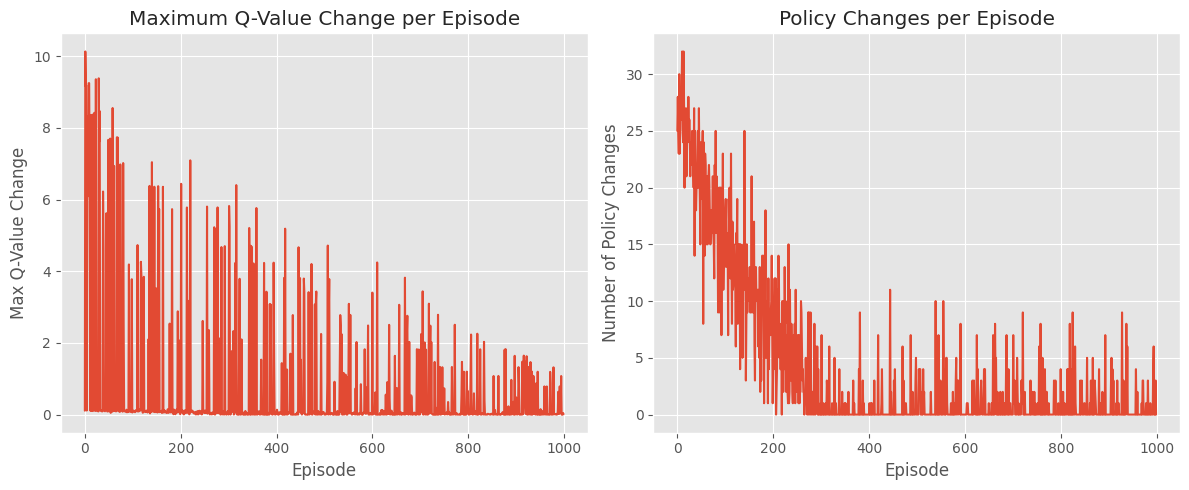

In [71]:
#Parameters:
num_episodes_q_learn_track = 1000
alpha_q_learn_track = 0.1
gamma_q_learn_track = 0.9
epsilon_q_learn_track = 0.1

def q_learning_trackQ(env, num_episodes=num_episodes_q_learn_track, alpha=alpha_q_learn_track,
                      gamma=gamma_q_learn_track, epsilon=epsilon_q_learn_track):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    max_q_change_per_episode = []
    policy_changes_per_episode = []

    for i_episode in range(num_episodes):
        state = env.reset()
        max_q_change = 0
        old_policy = [np.argmax(Q[s]) for s in range(env.observation_space.n)]
        while True:
            # Problem as state is a tuple the first time it is accessed, but an integer the following
            # Extract the state part if it's a tuple with additional info
            if isinstance(state, tuple):
                state = state[0]

            action = np.random.choice(env.action_space.n) if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, is_terminal, is_truncated, _ = env.step(action)
            old_value = Q[state][action]
            Q[state][action] += alpha * (reward + gamma * max(Q[next_state]) - old_value)

            # Track maximum Q-value change
            max_q_change = max(max_q_change, abs(old_value - Q[state][action]))

            if is_terminal:
                break
            state = next_state

        # Track how policy changes
        new_policy = [np.argmax(Q[s]) for s in range(env.observation_space.n)]
        policy_changes = sum(1 for old, new in zip(old_policy, new_policy) if old != new)
        policy_changes_per_episode.append(policy_changes)
        max_q_change_per_episode.append(max_q_change)

    return Q, max_q_change_per_episode, policy_changes_per_episode


# Assume you have a function to initialize your environment
#env = initialize_your_environment()
Q, max_q_changes, policy_changes = q_learning_trackQ(env)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(max_q_changes)
plt.title('Maximum Q-Value Change per Episode')
plt.xlabel('Episode')
plt.ylabel('Max Q-Value Change')

plt.subplot(1, 2, 2)
plt.plot(policy_changes)
plt.title('Policy Changes per Episode')
plt.xlabel('Episode')
plt.ylabel('Number of Policy Changes')

plt.tight_layout()
plt.show()


## Comparative Analysis of TD Learning Algorithms

Based on the provided plot for Q-learning, we can observe and speculate the following:

### Q-Learning:
- Initially experiences large maximal Q-value changes, indicating significant learning steps.
- The number of policy changes decreases over time, reflecting stabilization in policy as learning progresses.
- Exhibits rapid early learning with subsequent stabilization.

### Expected Behavior of Other Algorithms:

#### SARSA:
- SARSA would likely show more gradual changes in Q-values due to its on-policy nature, accounting for exploration.
- We would expect fewer policy changes per episode compared to Q-learning, as SARSA is more conservative due to exploration.

#### Double Q-Learning:
- Double Q-Learning would potentially show a smoother decrease in maximal Q-value changes, with less volatility than Q-learning due to reduced overestimation.
- Policy changes might not decrease as smoothly as with Q-learning, since two value estimators could lead to more frequent policy revisions.

#### Expected SARSA:
- Expected SARSA should demonstrate moderate maximal Q-value changes, as it balances between SARSA and Q-learning.
- Policy changes would be expected to decrease steadily, reflecting a more stable learning process that considers the expected outcome of all actions.

### Overall Comparison:
- **Q-Learning** may exhibit faster convergence but at the risk of higher volatility in policy changes.
- **SARSA** is expected to show a more cautious approach with smaller maximal Q-value changes and fewer policy changes.
- **Double Q-Learning** aims for accuracy in value estimation, potentially showing less dramatic initial changes but more consistent policy evolution.
- **Expected SARSA** balances the characteristics of SARSA and Q-learning and is likely to show intermediate behavior in both maximal Q-value and policy changes.

The actual behavior of SARSA, Double Q-Learning, and Expected SARSA would need to be confirmed by running these algorithms on the same task and comparing their plots to Q-learning's performance.
